<h1>Deep Reach</h1>

The following implementation is inspired by <h><a href="https://github.com/SimonBirrell/ppo-continuous-control">ppo-continuous-control</a></h> and <h><a href="https://github.com/higgsfield/RL-Adventure-2">RL-Adventure-2</a></h>.

<h2>Import, configure, and load reacher environment</h2>

In [1]:
# Import libaries
import math
import random
from collections import namedtuple, deque
import gym
import numpy as np

# Setup Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)

# Setup Cuda or CPU
use_cuda = torch.cuda.is_available()
DEVICE   = torch.device("cuda" if use_cuda else "cpu")

# Start Environment
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="./unity_simulation/Tennis.x86_64")

0.4.0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


<h2>Examine the reacher environement</h2>

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


<h2>Hyperparameters</h2>

In [3]:
HORIZON = 275           # Range 32 to 5000
DISCOUNT_FACTOR = 0.99  # Range 0.8 to 0.9997
GAE_DISCOUNT = 0.99     # Range 0.8 to 0.9997
GAE_LAMBDA = 0.95       # Range 0.9 to 1
EPOCH_RANGE = 12        # Range 3 to 30
MINIBATCH_SIZE = 64     # Range 4 to 4096
PPO_CLIP_RANGE = 0.15   # Range 0.05 to 0.3 [testing --> 0.05; 0.1; 0.15]
LEARNING_RATE = 3e-4    # Range 0.003 to 5e-6

<h2>Utilities</h2>

In [4]:
# Following is inspired/copied from:
# https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py    
class RunningMeanStd(object):
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)    
        
def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

class MeanStdNormalizer():
    def __init__(self):
        self.rms = None
        self.clip = 10.0
        self.epsilon = 1e-8

    def __call__(self, x):
        x = np.asarray(x)
        if self.rms is None:
            self.rms = RunningMeanStd(shape=(1, ) + x.shape[1:])
        self.rms.update(x)
        return np.clip((x - self.rms.mean) / np.sqrt(self.rms.var + self.epsilon),
                       -self.clip, self.clip)

<h2>Neural Network (actor/critic)</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_agents, state_size, action_size, hidden_size, seed):
        super(ActorCritic, self).__init__()
        
        self.seed = random.seed(seed)
        
        self.critic = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
        )
        
        self.log_std = nn.Parameter(torch.ones(1, action_size))
        self.apply(init_weights)
        
    def forward(self, obs, action=None):
        obs = torch.tensor(obs, device=DEVICE, dtype=torch.float32)
        a = self.actor(obs)
        v = self.critic(obs)
        dist = torch.distributions.Normal(a, self.log_std.exp().expand_as(a))
        return (v, dist)

<h2>Rollout manager</h2>

In [6]:
class Rollout_manager():
    
    def __init__(self):
        # Stored data
        self.actions = []
        self.log_prob_actions = []
        self.values = []
        self.rewards = []
        self.episode_not_dones = []
        self.states = []
        
        # Calculated data
        self.returns = [0.0] * HORIZON
        self.advantages = [0.0] * HORIZON
        
    def save_prediction(self, actions, log_prob_actions, values):
        self.actions.append(actions)
        self.log_prob_actions.append(log_prob_actions)
        self.values.append(values)

    def save_consequences(self, rewards, episode_not_dones, states):
        self.rewards.append(rewards)
        self.episode_not_dones.append(episode_not_dones)
        self.states.append(states)
        
    def calculate_returns_and_advantages(self, final_reward):
        self.rewards.append(None)
        self.episode_not_dones.append(None)
        self.calculate_future_returns(final_reward)
        self.estimate_advantages()

    def calculate_future_returns(self, returns):
        for i in reversed(range(HORIZON)):
            returns = self.rewards[i] + DISCOUNT_FACTOR * self.episode_not_dones[i] * returns
            self.returns[i] = returns.detach() 

    def estimate_advantages(self):
        advantages = torch.tensor(np.zeros((num_agents, 1)), device=DEVICE, dtype=torch.float32)
        for i in reversed(range(HORIZON)):
            td = self.rewards[i] + (GAE_DISCOUNT * self.episode_not_dones[i] * self.values[i + 1]) - self.values[i]
            advantages = advantages * GAE_LAMBDA * GAE_DISCOUNT * self.episode_not_dones[i] + td
            self.advantages[i] = advantages.detach()               

    def stack_tensor(self, some_list):
        return torch.cat(some_list[:HORIZON], dim=0)
            
    def get_data(self):
        states = self.stack_tensor(self.states)
        actions = self.stack_tensor(self.actions) 
        log_prob_actions = self.stack_tensor(self.log_prob_actions)
        returns = self.stack_tensor(self.returns)
        advantages = self.stack_tensor(self.advantages)
        advantages = (advantages - advantages.mean()) / advantages.std()        
        return (states, actions, log_prob_actions, returns, advantages)

<h2>PPO algorithm</h2>

In [7]:
class PPO_algorithm():   
    
    def __init__(self, num_agents, state_size, action_size, hidden_size, seed):
        self.network = ActorCritic(num_agents, state_size, action_size, hidden_size, seed).to(DEVICE)
        self.first_states = True
        self.state_normalizer = MeanStdNormalizer()
        
    def evaluate_actions_against_states(self, states, actions):
        value, action_distribution = self.network(states, actions)
        log_prob = action_distribution.log_prob(actions).sum(-1).unsqueeze(-1)
        return (log_prob, value)
    
    def get_prediction(self, states):
        if self.first_states:
            self.states = states
            self.first_states = False
        self.latest_values, action_distribution = self.network(self.states)
        self.latest_actions = action_distribution.sample()
        self.latest_log_prob = action_distribution.log_prob(self.latest_actions).sum(-1).unsqueeze(-1)
        return self.latest_actions
    
    def step(self, states, actions, rewards, next_states, dones):
        rewards = np.asarray(rewards)
        next_states = self.state_normalizer(next_states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
        dones = np.asarray(dones).astype(int)
        rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float32).unsqueeze(-1)
        episode_not_dones = torch.tensor((1 - dones), device=DEVICE, dtype=torch.float32).unsqueeze(-1)
        states = torch.tensor(self.states, device=DEVICE, dtype=torch.float32)      
        self.rollout.save_consequences(rewards, episode_not_dones, states)
        self.states = next_states
                
    def create_rollout(self):
        self.rollout = Rollout_manager()
            
    def process_rollout(self, states):
        # save final results
        self.get_prediction(states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
        # Calculate resutns and advantages
        self.rollout.calculate_returns_and_advantages(self.latest_values.detach())
        # Optimize
        self.optimize()
        self.first_states = True
   
    def save_weights(self):
        torch.save(self.network.state_dict(), "trained_weights.pth")
        print("Weights are saved to trained_weights.pth")
        
    def ppo_update(self, optimizer, sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages):
        log_prob_action, value = self.evaluate_actions_against_states(sampled_states, sampled_actions)
        
        # Policy Loss
        ratio = (log_prob_action - sampled_log_probs_old).exp() 
        obj = ratio * sampled_advantages
        obj_clipped = ratio.clamp(1.0 - PPO_CLIP_RANGE, 1.0 + PPO_CLIP_RANGE) * sampled_advantages
        policy_loss = -torch.min(obj, obj_clipped).mean() 
        
        # Value Loss
        value_loss = 0.5 * (sampled_returns - value).pow(2).mean()
        
        # Optimize network weights
        loss = policy_loss + value_loss
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.network.parameters(), 0.75) 
        optimizer.step()

    def optimize(self):
        states, actions, log_probs_old, returns, advantages = self.rollout.get_data()
        actions = actions.detach()
        log_probs_old = log_probs_old.detach()
        optimizer = torch.optim.Adam(self.network.parameters(), LEARNING_RATE, eps=1e-5)
        for i in range(EPOCH_RANGE):
            number_timesteps = states.size(0)
            timesteps_to_sample = random_sample(np.arange(number_timesteps), MINIBATCH_SIZE) 
            for timestep in timesteps_to_sample:
                t = torch.tensor(timestep, device=DEVICE, dtype=torch.float32).long()
                sampled_states = states[t]
                sampled_actions = actions[t]
                sampled_log_probs_old = log_probs_old[t]
                sampled_returns = returns[t]
                sampled_advantages = advantages[t]
                self.ppo_update(optimizer, sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages)

<h1>Train agent</h1>

In [8]:
class train_agent():
    
    def __init__(self, num_workers):
        self.num_workers = num_workers
        self.online_rewards = np.zeros(num_workers)
        self.running_mean_score = 0
        self.mean_scores = []
                
    def train_ppo(self, agent, target_avg_score, max_episodes=300, train_mode_=True):
        if train_mode_:
            print("========================================================================================")
            print("Beginning training...")
            print("GOAL: Mean episode score of {:.2f} over the last 100 episodes in less than {} episodes.".format(target_avg_score, max_episodes))
            print("========================================================================================")
        else:
            print("Testing Agent")
        
        # Reset environment:
        env_info = env.reset(train_mode=train_mode_)[brain_name]
        
        # Initialize variables:
        self.num_episodes = 0
        self.last_100_scores = deque(maxlen=100)
        self.episode_scores = [list() for i in range(num_agents)]
        self.episodes_finished = 0
        self.target_avg_score = target_avg_score
        
        while True:
            # Run a rollout (max HORIZON)
            states = env_info.vector_observations # Get current states
            scores = np.zeros(num_agents) # Initialize scores list
            agent.create_rollout() # Create rollout instance
            
            horizon_ = HORIZON

            for t in range(horizon_):
                # Get actions from policy
                actions = np.clip(agent.get_prediction(states).cpu().detach().numpy(), -1, 1) # Limit max torque between -1 and 1

                # Use the actions in the environemnt and get next state
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done

                # Save rewards
                self.online_rewards += rewards
                for i, done in enumerate(dones):
                    # If a worker is done end the episode for this worker
                    if done:
                        # Save the workers reward from the episode
                        self.episode_scores[i].append(self.online_rewards[i])
                        self.episodes_finished +=1
                        # If all workers finished end the entire episode
                        if (self.episodes_finished % num_agents) == 0:
                            max_score = -99.0
                            self.num_episodes += 1
                            # Add up the rewards that each agent received and pick max
                            for j in range(num_agents):
                                single_agent_acore = self.episode_scores[i][-1]
                                max_score = single_agent_acore if single_agent_acore > max_score else max_score
                            self.last_100_scores.append(max_score)
                            self.mean_scores.append(max_score)
                            if train_mode_:
                                print("Episode: %3.0f | Mean max score: %7.4f | Mean 100 episode score: %7.4f" % (self.num_episodes, round(max_score, 6), round(np.mean(self.last_100_scores),6)))
                        
                        env_info = env.reset(train_mode=train_mode_)[brain_name]
                        # Set accumulated reward to zero for next episode
                        self.online_rewards[i] = 0
                        # Calculate running mean
                        self.running_mean_score = np.mean(self.last_100_scores)
                        # Break if the target if reached 
                        if self.running_mean_score > self.target_avg_score and train_mode_:
                            print(" ")
                            print("*** Target reached! ***")
                            print(" ")
                            break

                agent.step(states, actions, rewards, next_states, dones) 
                scores += rewards
                states = next_states
                
            # Optimize the agent using PPO and the data from the last rollout
            agent.process_rollout(states)

            # Check exit conditions
            if self.running_mean_score > target_avg_score and train_mode_:
                print("Mean episode max score of %s over the last 100 episodes" % self.running_mean_score)
                agent.save_weights() 
                break
            if self.num_episodes > max_episodes and train_mode_:
                print("Failed mean episode max score of {:.2f} over the 100 most recent episodes in less than {} episodes.".format(target_avg_score, self.num_episodes))
                agent.save_weights() 
                break
        return self.mean_scores           

<h1> Train PPO agent </h1>

In [9]:
from numpy import savetxt
import warnings
warnings.filterwarnings('ignore') # ignore Rimtime Warnings

scores        = []
for i in range(5):
    agent         = PPO_algorithm(num_agents, state_size=state_size, action_size=action_size, hidden_size=32, seed=123)
    train_session = train_agent(num_agents)
    scores.append(train_session.train_ppo(agent, 100, 2500))
    
# Save scores to csv file:
episodes = []
scores_con = []
for i in range(len(scores)):
    episodes += range(len(scores[i]))
    scores_con += scores[i]
    
savetxt('./score.csv', np.c_[episodes,scores_con], delimiter=",")

Beginning training...
GOAL: Mean episode score of 100.00 over the last 100 episodes in less than 2500 episodes.
Episode:   1 | Mean max score: -0.0100 | Mean 100 episode score: -0.0100
Episode:   2 | Mean max score: -0.0100 | Mean 100 episode score: -0.0100
Episode:   3 | Mean max score:  0.0900 | Mean 100 episode score:  0.0233
Episode:   4 | Mean max score:  0.0900 | Mean 100 episode score:  0.0400
Episode:   5 | Mean max score:  0.0000 | Mean 100 episode score:  0.0320
Episode:   6 | Mean max score: -0.0100 | Mean 100 episode score:  0.0250
Episode:   7 | Mean max score: -0.0100 | Mean 100 episode score:  0.0200
Episode:   8 | Mean max score:  0.0900 | Mean 100 episode score:  0.0288
Episode:   9 | Mean max score: -0.0100 | Mean 100 episode score:  0.0244
Episode:  10 | Mean max score:  0.0000 | Mean 100 episode score:  0.0220
Episode:  11 | Mean max score: -0.0100 | Mean 100 episode score:  0.0191
Episode:  12 | Mean max score:  0.0000 | Mean 100 episode score:  0.0175
Episode:  13

Episode: 112 | Mean max score:  0.0000 | Mean 100 episode score:  0.0073
Episode: 113 | Mean max score: -0.0100 | Mean 100 episode score:  0.0063
Episode: 114 | Mean max score: -0.0100 | Mean 100 episode score:  0.0062
Episode: 115 | Mean max score: -0.0100 | Mean 100 episode score:  0.0061
Episode: 116 | Mean max score:  0.0000 | Mean 100 episode score:  0.0062
Episode: 117 | Mean max score: -0.0100 | Mean 100 episode score:  0.0062
Episode: 118 | Mean max score:  0.0900 | Mean 100 episode score:  0.0071
Episode: 119 | Mean max score:  0.0900 | Mean 100 episode score:  0.0081
Episode: 120 | Mean max score:  0.0000 | Mean 100 episode score:  0.0082
Episode: 121 | Mean max score: -0.0100 | Mean 100 episode score:  0.0081
Episode: 122 | Mean max score: -0.0100 | Mean 100 episode score:  0.0081
Episode: 123 | Mean max score: -0.0100 | Mean 100 episode score:  0.0081
Episode: 124 | Mean max score: -0.0100 | Mean 100 episode score:  0.0071
Episode: 125 | Mean max score:  0.0000 | Mean 100 e

Episode: 231 | Mean max score:  0.0000 | Mean 100 episode score:  0.0089
Episode: 232 | Mean max score:  0.0000 | Mean 100 episode score:  0.0079
Episode: 233 | Mean max score: -0.0100 | Mean 100 episode score:  0.0078
Episode: 234 | Mean max score: -0.0100 | Mean 100 episode score:  0.0078
Episode: 235 | Mean max score:  0.0000 | Mean 100 episode score:  0.0079
Episode: 236 | Mean max score:  0.0000 | Mean 100 episode score:  0.0080
Episode: 237 | Mean max score:  0.0000 | Mean 100 episode score:  0.0071
Episode: 238 | Mean max score:  0.0000 | Mean 100 episode score:  0.0072
Episode: 239 | Mean max score:  0.0900 | Mean 100 episode score:  0.0081
Episode: 240 | Mean max score: -0.0100 | Mean 100 episode score:  0.0080
Episode: 241 | Mean max score:  0.0900 | Mean 100 episode score:  0.0089
Episode: 242 | Mean max score:  0.0000 | Mean 100 episode score:  0.0090
Episode: 243 | Mean max score: -0.0100 | Mean 100 episode score:  0.0090
Episode: 244 | Mean max score: -0.0100 | Mean 100 e

Episode: 346 | Mean max score:  0.1000 | Mean 100 episode score:  0.0148
Episode: 347 | Mean max score:  0.0000 | Mean 100 episode score:  0.0149
Episode: 348 | Mean max score:  0.0900 | Mean 100 episode score:  0.0159
Episode: 349 | Mean max score:  0.0000 | Mean 100 episode score:  0.0160
Episode: 350 | Mean max score: -0.0100 | Mean 100 episode score:  0.0159
Episode: 351 | Mean max score:  0.0000 | Mean 100 episode score:  0.0160
Episode: 352 | Mean max score: -0.0100 | Mean 100 episode score:  0.0159
Episode: 353 | Mean max score: -0.0100 | Mean 100 episode score:  0.0159
Episode: 354 | Mean max score: -0.0100 | Mean 100 episode score:  0.0159
Episode: 355 | Mean max score:  0.2900 | Mean 100 episode score:  0.0188
Episode: 356 | Mean max score: -0.0100 | Mean 100 episode score:  0.0187
Episode: 357 | Mean max score:  0.0900 | Mean 100 episode score:  0.0187
Episode: 358 | Mean max score: -0.0100 | Mean 100 episode score:  0.0187
Episode: 359 | Mean max score:  0.0000 | Mean 100 e

Episode: 460 | Mean max score:  0.0900 | Mean 100 episode score:  0.0228
Episode: 461 | Mean max score: -0.0100 | Mean 100 episode score:  0.0228
Episode: 462 | Mean max score: -0.0100 | Mean 100 episode score:  0.0228
Episode: 463 | Mean max score: -0.0100 | Mean 100 episode score:  0.0218
Episode: 464 | Mean max score:  0.0900 | Mean 100 episode score:  0.0228
Episode: 465 | Mean max score:  0.0000 | Mean 100 episode score:  0.0229
Episode: 466 | Mean max score:  0.0900 | Mean 100 episode score:  0.0239
Episode: 467 | Mean max score:  0.0000 | Mean 100 episode score:  0.0240
Episode: 468 | Mean max score:  0.0900 | Mean 100 episode score:  0.0249
Episode: 469 | Mean max score: -0.0100 | Mean 100 episode score:  0.0248
Episode: 470 | Mean max score: -0.0100 | Mean 100 episode score:  0.0237
Episode: 471 | Mean max score: -0.0100 | Mean 100 episode score:  0.0237
Episode: 472 | Mean max score: -0.0100 | Mean 100 episode score:  0.0226
Episode: 473 | Mean max score: -0.0100 | Mean 100 e

Episode: 576 | Mean max score:  0.0900 | Mean 100 episode score:  0.0415
Episode: 577 | Mean max score:  0.0900 | Mean 100 episode score:  0.0425
Episode: 578 | Mean max score:  0.1000 | Mean 100 episode score:  0.0426
Episode: 579 | Mean max score:  0.0900 | Mean 100 episode score:  0.0435
Episode: 580 | Mean max score:  0.0900 | Mean 100 episode score:  0.0434
Episode: 581 | Mean max score:  0.0900 | Mean 100 episode score:  0.0443
Episode: 582 | Mean max score: -0.0100 | Mean 100 episode score:  0.0433
Episode: 583 | Mean max score:  0.0000 | Mean 100 episode score:  0.0434
Episode: 584 | Mean max score:  0.1000 | Mean 100 episode score:  0.0435
Episode: 585 | Mean max score: -0.0100 | Mean 100 episode score:  0.0435
Episode: 586 | Mean max score: -0.0100 | Mean 100 episode score:  0.0434
Episode: 587 | Mean max score:  0.0900 | Mean 100 episode score:  0.0434
Episode: 588 | Mean max score: -0.0100 | Mean 100 episode score:  0.0433
Episode: 589 | Mean max score:  0.0000 | Mean 100 e

Episode: 690 | Mean max score: -0.0100 | Mean 100 episode score:  0.0364
Episode: 691 | Mean max score:  0.0900 | Mean 100 episode score:  0.0373
Episode: 692 | Mean max score:  0.0000 | Mean 100 episode score:  0.0353
Episode: 693 | Mean max score:  0.1900 | Mean 100 episode score:  0.0372
Episode: 694 | Mean max score:  0.0900 | Mean 100 episode score:  0.0372
Episode: 695 | Mean max score: -0.0100 | Mean 100 episode score:  0.0362
Episode: 696 | Mean max score:  0.0900 | Mean 100 episode score:  0.0372
Episode: 697 | Mean max score: -0.0100 | Mean 100 episode score:  0.0372
Episode: 698 | Mean max score:  0.2900 | Mean 100 episode score:  0.0402
Episode: 699 | Mean max score:  0.0000 | Mean 100 episode score:  0.0403
Episode: 700 | Mean max score:  0.1900 | Mean 100 episode score:  0.0423
Episode: 701 | Mean max score:  0.0900 | Mean 100 episode score:  0.0423
Episode: 702 | Mean max score:  0.0900 | Mean 100 episode score:  0.0433
Episode: 703 | Mean max score: -0.0100 | Mean 100 e

Episode: 807 | Mean max score:  0.1000 | Mean 100 episode score:  0.0390
Episode: 808 | Mean max score:  0.0900 | Mean 100 episode score:  0.0389
Episode: 809 | Mean max score:  0.0900 | Mean 100 episode score:  0.0399
Episode: 810 | Mean max score: -0.0100 | Mean 100 episode score:  0.0368
Episode: 811 | Mean max score:  0.0900 | Mean 100 episode score:  0.0377
Episode: 812 | Mean max score: -0.0100 | Mean 100 episode score:  0.0377
Episode: 813 | Mean max score: -0.0100 | Mean 100 episode score:  0.0367
Episode: 814 | Mean max score: -0.0100 | Mean 100 episode score:  0.0367
Episode: 815 | Mean max score: -0.0100 | Mean 100 episode score:  0.0367
Episode: 816 | Mean max score: -0.0100 | Mean 100 episode score:  0.0366
Episode: 817 | Mean max score: -0.0100 | Mean 100 episode score:  0.0366
Episode: 818 | Mean max score:  0.1000 | Mean 100 episode score:  0.0366
Episode: 819 | Mean max score:  0.0000 | Mean 100 episode score:  0.0367
Episode: 820 | Mean max score:  0.1000 | Mean 100 e

Episode: 922 | Mean max score:  0.1900 | Mean 100 episode score:  0.0688
Episode: 923 | Mean max score: -0.0100 | Mean 100 episode score:  0.0688
Episode: 924 | Mean max score:  0.0900 | Mean 100 episode score:  0.0688
Episode: 925 | Mean max score:  0.0000 | Mean 100 episode score:  0.0689
Episode: 926 | Mean max score:  0.1000 | Mean 100 episode score:  0.0699
Episode: 927 | Mean max score:  0.1900 | Mean 100 episode score:  0.0708
Episode: 928 | Mean max score:  0.1000 | Mean 100 episode score:  0.0708
Episode: 929 | Mean max score: -0.0100 | Mean 100 episode score:  0.0708
Episode: 930 | Mean max score: -0.0100 | Mean 100 episode score:  0.0708
Episode: 931 | Mean max score:  0.2900 | Mean 100 episode score:  0.0738
Episode: 932 | Mean max score: -0.0100 | Mean 100 episode score:  0.0737
Episode: 933 | Mean max score: -0.0100 | Mean 100 episode score:  0.0736
Episode: 934 | Mean max score:  0.4000 | Mean 100 episode score:  0.0777
Episode: 935 | Mean max score:  0.0900 | Mean 100 e

Episode: 1036 | Mean max score: -0.0100 | Mean 100 episode score:  0.0875
Episode: 1037 | Mean max score: -0.0100 | Mean 100 episode score:  0.0875
Episode: 1038 | Mean max score:  0.0900 | Mean 100 episode score:  0.0865
Episode: 1039 | Mean max score:  0.2000 | Mean 100 episode score:  0.0876
Episode: 1040 | Mean max score:  0.0900 | Mean 100 episode score:  0.0866
Episode: 1041 | Mean max score: -0.0100 | Mean 100 episode score:  0.0846
Episode: 1042 | Mean max score: -0.0100 | Mean 100 episode score:  0.0826
Episode: 1043 | Mean max score:  0.1000 | Mean 100 episode score:  0.0826
Episode: 1044 | Mean max score: -0.0100 | Mean 100 episode score:  0.0826
Episode: 1045 | Mean max score:  0.0900 | Mean 100 episode score:  0.0825
Episode: 1046 | Mean max score: -0.0100 | Mean 100 episode score:  0.0825
Episode: 1047 | Mean max score:  0.1000 | Mean 100 episode score:  0.0836
Episode: 1048 | Mean max score: -0.0100 | Mean 100 episode score:  0.0826
Episode: 1049 | Mean max score: -0.010

Episode: 1148 | Mean max score:  0.0900 | Mean 100 episode score:  0.1065
Episode: 1149 | Mean max score: -0.0100 | Mean 100 episode score:  0.1065
Episode: 1150 | Mean max score:  0.0900 | Mean 100 episode score:  0.1065
Episode: 1151 | Mean max score:  0.0000 | Mean 100 episode score:  0.1055
Episode: 1152 | Mean max score:  0.1900 | Mean 100 episode score:  0.1075
Episode: 1153 | Mean max score:  0.1900 | Mean 100 episode score:  0.1085
Episode: 1154 | Mean max score:  0.0900 | Mean 100 episode score:  0.1085
Episode: 1155 | Mean max score:  0.1900 | Mean 100 episode score:  0.1105
Episode: 1156 | Mean max score: -0.0100 | Mean 100 episode score:  0.1105
Episode: 1157 | Mean max score:  0.1900 | Mean 100 episode score:  0.1125
Episode: 1158 | Mean max score:  0.1000 | Mean 100 episode score:  0.1125
Episode: 1159 | Mean max score: -0.0100 | Mean 100 episode score:  0.1105
Episode: 1160 | Mean max score:  0.0900 | Mean 100 episode score:  0.1115
Episode: 1161 | Mean max score:  0.090

Episode: 1259 | Mean max score:  0.2900 | Mean 100 episode score:  0.1208
Episode: 1260 | Mean max score:  0.1000 | Mean 100 episode score:  0.1209
Episode: 1261 | Mean max score:  0.6000 | Mean 100 episode score:  0.1260
Episode: 1262 | Mean max score:  0.1000 | Mean 100 episode score:  0.1261
Episode: 1263 | Mean max score:  0.0900 | Mean 100 episode score:  0.1261
Episode: 1264 | Mean max score:  0.0000 | Mean 100 episode score:  0.1242
Episode: 1265 | Mean max score:  0.1000 | Mean 100 episode score:  0.1253
Episode: 1266 | Mean max score: -0.0100 | Mean 100 episode score:  0.1243
Episode: 1267 | Mean max score: -0.0100 | Mean 100 episode score:  0.1222
Episode: 1268 | Mean max score:  0.4900 | Mean 100 episode score:  0.1262
Episode: 1269 | Mean max score:  0.1000 | Mean 100 episode score:  0.1263
Episode: 1270 | Mean max score:  0.6000 | Mean 100 episode score:  0.1304
Episode: 1271 | Mean max score:  0.0900 | Mean 100 episode score:  0.1303
Episode: 1272 | Mean max score: -0.010

Episode: 1370 | Mean max score: -0.0100 | Mean 100 episode score:  0.2973
Episode: 1371 | Mean max score:  1.3900 | Mean 100 episode score:  0.3103
Episode: 1372 | Mean max score: -0.0100 | Mean 100 episode score:  0.3103
Episode: 1373 | Mean max score:  0.2900 | Mean 100 episode score:  0.3133
Episode: 1374 | Mean max score:  0.2000 | Mean 100 episode score:  0.3074
Episode: 1375 | Mean max score:  0.2000 | Mean 100 episode score:  0.3045
Episode: 1376 | Mean max score: -0.0100 | Mean 100 episode score:  0.3035
Episode: 1377 | Mean max score:  0.2000 | Mean 100 episode score:  0.2946
Episode: 1378 | Mean max score: -0.0100 | Mean 100 episode score:  0.2925
Episode: 1379 | Mean max score: -0.0100 | Mean 100 episode score:  0.2845
Episode: 1380 | Mean max score:  0.0900 | Mean 100 episode score:  0.2844
Episode: 1381 | Mean max score:  0.0900 | Mean 100 episode score:  0.2843
Episode: 1382 | Mean max score:  0.2900 | Mean 100 episode score:  0.2862
Episode: 1383 | Mean max score:  0.400

Episode: 1481 | Mean max score:  1.3000 | Mean 100 episode score:  0.6228
Episode: 1482 | Mean max score:  0.9000 | Mean 100 episode score:  0.6289
Episode: 1483 | Mean max score:  0.6900 | Mean 100 episode score:  0.6318
Episode: 1484 | Mean max score:  0.3900 | Mean 100 episode score:  0.6348
Episode: 1485 | Mean max score:  0.0900 | Mean 100 episode score:  0.6317
Episode: 1486 | Mean max score:  0.9900 | Mean 100 episode score:  0.6337
Episode: 1487 | Mean max score:  1.6000 | Mean 100 episode score:  0.6498
Episode: 1488 | Mean max score:  1.2000 | Mean 100 episode score:  0.6518
Episode: 1489 | Mean max score:  0.5000 | Mean 100 episode score:  0.6508
Episode: 1490 | Mean max score:  0.6900 | Mean 100 episode score:  0.6578
Episode: 1491 | Mean max score:  0.2900 | Mean 100 episode score:  0.6528
Episode: 1492 | Mean max score:  1.9900 | Mean 100 episode score:  0.6708
Episode: 1493 | Mean max score:  1.8000 | Mean 100 episode score:  0.6849
Episode: 1494 | Mean max score:  0.090

Episode: 1592 | Mean max score:  1.5900 | Mean 100 episode score:  0.8048
Episode: 1593 | Mean max score:  2.2900 | Mean 100 episode score:  0.8097
Episode: 1594 | Mean max score:  0.6000 | Mean 100 episode score:  0.8148
Episode: 1595 | Mean max score:  0.0900 | Mean 100 episode score:  0.8148
Episode: 1596 | Mean max score:  2.6000 | Mean 100 episode score:  0.8339
Episode: 1597 | Mean max score:  0.0000 | Mean 100 episode score:  0.8290
Episode: 1598 | Mean max score:  2.6000 | Mean 100 episode score:  0.8461
Episode: 1599 | Mean max score:  0.5000 | Mean 100 episode score:  0.8411
Episode: 1600 | Mean max score:  2.6000 | Mean 100 episode score:  0.8651
Episode: 1601 | Mean max score:  0.0900 | Mean 100 episode score:  0.8520
Episode: 1602 | Mean max score:  2.6000 | Mean 100 episode score:  0.8781
Episode: 1603 | Mean max score: -0.0100 | Mean 100 episode score:  0.8781
Episode: 1604 | Mean max score:  2.5900 | Mean 100 episode score:  0.9001
Episode: 1605 | Mean max score:  2.600

Episode: 1703 | Mean max score:  1.9000 | Mean 100 episode score:  1.1394
Episode: 1704 | Mean max score:  1.7000 | Mean 100 episode score:  1.1305
Episode: 1705 | Mean max score:  1.1000 | Mean 100 episode score:  1.1155
Episode: 1706 | Mean max score:  2.6000 | Mean 100 episode score:  1.1415
Episode: 1707 | Mean max score:  2.6000 | Mean 100 episode score:  1.1415
Episode: 1708 | Mean max score:  2.1000 | Mean 100 episode score:  1.1506
Episode: 1709 | Mean max score:  2.6000 | Mean 100 episode score:  1.1617
Episode: 1710 | Mean max score:  2.6000 | Mean 100 episode score:  1.1838
Episode: 1711 | Mean max score:  0.3900 | Mean 100 episode score:  1.1867
Episode: 1712 | Mean max score:  0.0900 | Mean 100 episode score:  1.1766
Episode: 1713 | Mean max score:  0.0900 | Mean 100 episode score:  1.1745
Episode: 1714 | Mean max score:  0.1000 | Mean 100 episode score:  1.1495
Episode: 1715 | Mean max score:  0.0900 | Mean 100 episode score:  1.1505
Episode: 1716 | Mean max score:  0.400

Episode: 1814 | Mean max score:  1.6900 | Mean 100 episode score:  0.6718
Episode: 1815 | Mean max score:  0.0900 | Mean 100 episode score:  0.6718
Episode: 1816 | Mean max score:  0.4900 | Mean 100 episode score:  0.6727
Episode: 1817 | Mean max score:  0.4000 | Mean 100 episode score:  0.6758
Episode: 1818 | Mean max score: -0.0100 | Mean 100 episode score:  0.6728
Episode: 1819 | Mean max score:  2.6000 | Mean 100 episode score:  0.6808
Episode: 1820 | Mean max score: -0.0100 | Mean 100 episode score:  0.6627
Episode: 1821 | Mean max score:  2.6000 | Mean 100 episode score:  0.6877
Episode: 1822 | Mean max score: -0.0100 | Mean 100 episode score:  0.6866
Episode: 1823 | Mean max score:  0.0900 | Mean 100 episode score:  0.6866
Episode: 1824 | Mean max score:  0.4900 | Mean 100 episode score:  0.6916
Episode: 1825 | Mean max score:  1.6000 | Mean 100 episode score:  0.7057
Episode: 1826 | Mean max score:  1.3900 | Mean 100 episode score:  0.7187
Episode: 1827 | Mean max score:  0.690

Episode: 1926 | Mean max score:  0.7000 | Mean 100 episode score:  1.0722
Episode: 1927 | Mean max score:  0.1000 | Mean 100 episode score:  1.0663
Episode: 1928 | Mean max score:  1.2000 | Mean 100 episode score:  1.0754
Episode: 1929 | Mean max score:  0.7000 | Mean 100 episode score:  1.0564
Episode: 1930 | Mean max score:  0.3000 | Mean 100 episode score:  1.0595
Episode: 1931 | Mean max score:  0.1000 | Mean 100 episode score:  1.0345
Episode: 1932 | Mean max score:  1.2000 | Mean 100 episode score:  1.0466
Episode: 1933 | Mean max score:  0.3000 | Mean 100 episode score:  1.0236
Episode: 1934 | Mean max score:  0.1000 | Mean 100 episode score:  1.0246
Episode: 1935 | Mean max score:  0.2000 | Mean 100 episode score:  1.0006
Episode: 1936 | Mean max score:  0.7000 | Mean 100 episode score:  1.0077
Episode: 1937 | Mean max score:  0.1000 | Mean 100 episode score:  0.9827
Episode: 1938 | Mean max score:  2.1900 | Mean 100 episode score:  1.0047
Episode: 1939 | Mean max score:  0.600

Episode: 2037 | Mean max score:  0.4900 | Mean 100 episode score:  0.9908
Episode: 2038 | Mean max score:  0.1000 | Mean 100 episode score:  0.9699
Episode: 2039 | Mean max score:  0.0900 | Mean 100 episode score:  0.9648
Episode: 2040 | Mean max score:  0.0900 | Mean 100 episode score:  0.9647
Episode: 2041 | Mean max score:  0.7900 | Mean 100 episode score:  0.9576
Episode: 2042 | Mean max score:  0.4000 | Mean 100 episode score:  0.9606
Episode: 2043 | Mean max score:  0.3000 | Mean 100 episode score:  0.9597
Episode: 2044 | Mean max score:  0.1900 | Mean 100 episode score:  0.9596
Episode: 2045 | Mean max score:  0.3000 | Mean 100 episode score:  0.9616
Episode: 2046 | Mean max score: -0.0100 | Mean 100 episode score:  0.9605
Episode: 2047 | Mean max score:  0.5000 | Mean 100 episode score:  0.9515
Episode: 2048 | Mean max score:  0.1000 | Mean 100 episode score:  0.9496
Episode: 2049 | Mean max score:  0.5900 | Mean 100 episode score:  0.9545
Episode: 2050 | Mean max score:  0.290

Episode: 2148 | Mean max score:  0.4900 | Mean 100 episode score:  0.5911
Episode: 2149 | Mean max score:  0.2900 | Mean 100 episode score:  0.5881
Episode: 2150 | Mean max score:  0.0900 | Mean 100 episode score:  0.5861
Episode: 2151 | Mean max score:  0.2900 | Mean 100 episode score:  0.5831
Episode: 2152 | Mean max score:  0.4000 | Mean 100 episode score:  0.5761
Episode: 2153 | Mean max score:  0.3000 | Mean 100 episode score:  0.5771
Episode: 2154 | Mean max score:  0.0900 | Mean 100 episode score:  0.5771
Episode: 2155 | Mean max score:  0.8000 | Mean 100 episode score:  0.5832
Episode: 2156 | Mean max score: -0.0100 | Mean 100 episode score:  0.5822
Episode: 2157 | Mean max score:  1.4900 | Mean 100 episode score:  0.5951
Episode: 2158 | Mean max score:  0.5900 | Mean 100 episode score:  0.6001
Episode: 2159 | Mean max score:  0.0900 | Mean 100 episode score:  0.5961
Episode: 2160 | Mean max score:  1.1900 | Mean 100 episode score:  0.6071
Episode: 2161 | Mean max score:  0.700

Episode: 2259 | Mean max score:  2.6000 | Mean 100 episode score:  0.9197
Episode: 2260 | Mean max score:  0.0900 | Mean 100 episode score:  0.9087
Episode: 2261 | Mean max score:  2.6000 | Mean 100 episode score:  0.9277
Episode: 2262 | Mean max score: -0.0100 | Mean 100 episode score:  0.9266
Episode: 2263 | Mean max score:  0.3000 | Mean 100 episode score:  0.9146
Episode: 2264 | Mean max score:  1.5900 | Mean 100 episode score:  0.9296
Episode: 2265 | Mean max score:  0.8900 | Mean 100 episode score:  0.9375
Episode: 2266 | Mean max score:  1.1900 | Mean 100 episode score:  0.9465
Episode: 2267 | Mean max score:  0.9900 | Mean 100 episode score:  0.9514
Episode: 2268 | Mean max score:  2.6000 | Mean 100 episode score:  0.9754
Episode: 2269 | Mean max score: -0.0100 | Mean 100 episode score:  0.9693
Episode: 2270 | Mean max score:  0.9900 | Mean 100 episode score:  0.9772
Episode: 2271 | Mean max score:  2.6000 | Mean 100 episode score:  0.9943
Episode: 2272 | Mean max score: -0.010

Episode: 2370 | Mean max score:  0.4000 | Mean 100 episode score:  0.4940
Episode: 2371 | Mean max score:  0.4000 | Mean 100 episode score:  0.4720
Episode: 2372 | Mean max score:  0.3900 | Mean 100 episode score:  0.4760
Episode: 2373 | Mean max score:  1.0900 | Mean 100 episode score:  0.4780
Episode: 2374 | Mean max score:  0.1900 | Mean 100 episode score:  0.4719
Episode: 2375 | Mean max score:  0.5900 | Mean 100 episode score:  0.4579
Episode: 2376 | Mean max score:  2.6000 | Mean 100 episode score:  0.4800
Episode: 2377 | Mean max score:  0.1000 | Mean 100 episode score:  0.4800
Episode: 2378 | Mean max score:  0.6000 | Mean 100 episode score:  0.4740
Episode: 2379 | Mean max score:  2.6000 | Mean 100 episode score:  0.4900
Episode: 2380 | Mean max score:  0.1000 | Mean 100 episode score:  0.4810
Episode: 2381 | Mean max score:  2.6000 | Mean 100 episode score:  0.4921
Episode: 2382 | Mean max score:  0.0000 | Mean 100 episode score:  0.4922
Episode: 2383 | Mean max score:  0.100

Episode: 2483 | Mean max score:  0.6000 | Mean 100 episode score:  0.8440
Episode: 2484 | Mean max score:  0.3900 | Mean 100 episode score:  0.8290
Episode: 2485 | Mean max score:  0.4000 | Mean 100 episode score:  0.8321
Episode: 2486 | Mean max score:  2.6000 | Mean 100 episode score:  0.8522
Episode: 2487 | Mean max score:  0.2000 | Mean 100 episode score:  0.8533
Episode: 2488 | Mean max score:  0.1900 | Mean 100 episode score:  0.8473
Episode: 2489 | Mean max score:  0.1000 | Mean 100 episode score:  0.8424
Episode: 2490 | Mean max score:  0.1000 | Mean 100 episode score:  0.8384
Episode: 2491 | Mean max score:  1.4000 | Mean 100 episode score:  0.8495
Episode: 2492 | Mean max score: -0.0100 | Mean 100 episode score:  0.8335
Episode: 2493 | Mean max score:  0.8000 | Mean 100 episode score:  0.8306
Episode: 2494 | Mean max score:  0.8900 | Mean 100 episode score:  0.8375
Episode: 2495 | Mean max score: -0.0100 | Mean 100 episode score:  0.8375
Episode: 2496 | Mean max score:  0.990

Episode:  88 | Mean max score:  0.0000 | Mean 100 episode score:  0.0059
Episode:  89 | Mean max score: -0.0100 | Mean 100 episode score:  0.0057
Episode:  90 | Mean max score: -0.0100 | Mean 100 episode score:  0.0056
Episode:  91 | Mean max score: -0.0100 | Mean 100 episode score:  0.0054
Episode:  92 | Mean max score: -0.0100 | Mean 100 episode score:  0.0052
Episode:  93 | Mean max score:  0.0000 | Mean 100 episode score:  0.0052
Episode:  94 | Mean max score: -0.0100 | Mean 100 episode score:  0.0050
Episode:  95 | Mean max score:  0.0000 | Mean 100 episode score:  0.0049
Episode:  96 | Mean max score:  0.0000 | Mean 100 episode score:  0.0049
Episode:  97 | Mean max score:  0.0000 | Mean 100 episode score:  0.0048
Episode:  98 | Mean max score: -0.0100 | Mean 100 episode score:  0.0047
Episode:  99 | Mean max score: -0.0100 | Mean 100 episode score:  0.0045
Episode: 100 | Mean max score: -0.0100 | Mean 100 episode score:  0.0044
Episode: 101 | Mean max score:  0.0000 | Mean 100 e

Episode: 201 | Mean max score:  0.0900 | Mean 100 episode score:  0.0173
Episode: 202 | Mean max score: -0.0100 | Mean 100 episode score:  0.0173
Episode: 203 | Mean max score:  0.0000 | Mean 100 episode score:  0.0173
Episode: 204 | Mean max score: -0.0100 | Mean 100 episode score:  0.0173
Episode: 205 | Mean max score:  0.0000 | Mean 100 episode score:  0.0174
Episode: 206 | Mean max score:  0.0900 | Mean 100 episode score:  0.0174
Episode: 207 | Mean max score: -0.0100 | Mean 100 episode score:  0.0174
Episode: 208 | Mean max score:  0.0900 | Mean 100 episode score:  0.0183
Episode: 209 | Mean max score:  0.0900 | Mean 100 episode score:  0.0193
Episode: 210 | Mean max score: -0.0100 | Mean 100 episode score:  0.0193
Episode: 211 | Mean max score:  0.0900 | Mean 100 episode score:  0.0202
Episode: 212 | Mean max score:  0.1000 | Mean 100 episode score:  0.0203
Episode: 213 | Mean max score: -0.0100 | Mean 100 episode score:  0.0202
Episode: 214 | Mean max score: -0.0100 | Mean 100 e

Episode: 314 | Mean max score: -0.0100 | Mean 100 episode score:  0.0217
Episode: 315 | Mean max score:  0.0900 | Mean 100 episode score:  0.0227
Episode: 316 | Mean max score:  0.0000 | Mean 100 episode score:  0.0218
Episode: 317 | Mean max score:  0.0000 | Mean 100 episode score:  0.0218
Episode: 318 | Mean max score: -0.0100 | Mean 100 episode score:  0.0218
Episode: 319 | Mean max score:  0.0000 | Mean 100 episode score:  0.0218
Episode: 320 | Mean max score:  0.1000 | Mean 100 episode score:  0.0229
Episode: 321 | Mean max score:  0.0000 | Mean 100 episode score:  0.0230
Episode: 322 | Mean max score: -0.0100 | Mean 100 episode score:  0.0220
Episode: 323 | Mean max score:  0.0900 | Mean 100 episode score:  0.0230
Episode: 324 | Mean max score:  0.0000 | Mean 100 episode score:  0.0231
Episode: 325 | Mean max score:  0.0900 | Mean 100 episode score:  0.0241
Episode: 326 | Mean max score:  0.0000 | Mean 100 episode score:  0.0242
Episode: 327 | Mean max score:  0.0000 | Mean 100 e

Episode: 429 | Mean max score:  0.0000 | Mean 100 episode score:  0.0384
Episode: 430 | Mean max score:  0.1000 | Mean 100 episode score:  0.0395
Episode: 431 | Mean max score:  0.0900 | Mean 100 episode score:  0.0405
Episode: 432 | Mean max score:  0.1900 | Mean 100 episode score:  0.0414
Episode: 433 | Mean max score:  0.0900 | Mean 100 episode score:  0.0424
Episode: 434 | Mean max score:  0.0900 | Mean 100 episode score:  0.0434
Episode: 435 | Mean max score: -0.0100 | Mean 100 episode score:  0.0434
Episode: 436 | Mean max score:  0.0900 | Mean 100 episode score:  0.0444
Episode: 437 | Mean max score: -0.0100 | Mean 100 episode score:  0.0443
Episode: 438 | Mean max score:  0.0900 | Mean 100 episode score:  0.0443
Episode: 439 | Mean max score:  0.0900 | Mean 100 episode score:  0.0443
Episode: 440 | Mean max score: -0.0100 | Mean 100 episode score:  0.0442
Episode: 441 | Mean max score:  0.1000 | Mean 100 episode score:  0.0452
Episode: 442 | Mean max score:  0.0900 | Mean 100 e

Episode: 544 | Mean max score: -0.0100 | Mean 100 episode score:  0.0628
Episode: 545 | Mean max score:  0.0900 | Mean 100 episode score:  0.0638
Episode: 546 | Mean max score:  0.0900 | Mean 100 episode score:  0.0648
Episode: 547 | Mean max score:  0.0900 | Mean 100 episode score:  0.0657
Episode: 548 | Mean max score:  0.0900 | Mean 100 episode score:  0.0657
Episode: 549 | Mean max score: -0.0100 | Mean 100 episode score:  0.0657
Episode: 550 | Mean max score: -0.0100 | Mean 100 episode score:  0.0647
Episode: 551 | Mean max score:  0.0900 | Mean 100 episode score:  0.0647
Episode: 552 | Mean max score:  0.0900 | Mean 100 episode score:  0.0647
Episode: 553 | Mean max score:  0.1000 | Mean 100 episode score:  0.0658
Episode: 554 | Mean max score:  0.0000 | Mean 100 episode score:  0.0649
Episode: 555 | Mean max score:  0.1000 | Mean 100 episode score:  0.0650
Episode: 556 | Mean max score:  0.0900 | Mean 100 episode score:  0.0660
Episode: 557 | Mean max score:  0.0900 | Mean 100 e

Episode: 659 | Mean max score:  0.1000 | Mean 100 episode score:  0.0579
Episode: 660 | Mean max score:  0.1000 | Mean 100 episode score:  0.0580
Episode: 661 | Mean max score:  0.0900 | Mean 100 episode score:  0.0579
Episode: 662 | Mean max score:  0.0900 | Mean 100 episode score:  0.0579
Episode: 663 | Mean max score:  0.1900 | Mean 100 episode score:  0.0589
Episode: 664 | Mean max score:  0.0000 | Mean 100 episode score:  0.0580
Episode: 665 | Mean max score:  0.1900 | Mean 100 episode score:  0.0590
Episode: 666 | Mean max score:  0.0900 | Mean 100 episode score:  0.0600
Episode: 667 | Mean max score:  0.1000 | Mean 100 episode score:  0.0611
Episode: 668 | Mean max score:  0.0900 | Mean 100 episode score:  0.0611
Episode: 669 | Mean max score: -0.0100 | Mean 100 episode score:  0.0611
Episode: 670 | Mean max score: -0.0100 | Mean 100 episode score:  0.0611
Episode: 671 | Mean max score:  0.1000 | Mean 100 episode score:  0.0612
Episode: 672 | Mean max score:  0.0900 | Mean 100 e

Episode: 772 | Mean max score:  0.6900 | Mean 100 episode score:  0.1406
Episode: 773 | Mean max score:  0.1000 | Mean 100 episode score:  0.1397
Episode: 774 | Mean max score:  0.0900 | Mean 100 episode score:  0.1407
Episode: 775 | Mean max score: -0.0100 | Mean 100 episode score:  0.1396
Episode: 776 | Mean max score: -0.0100 | Mean 100 episode score:  0.1385
Episode: 777 | Mean max score: -0.0100 | Mean 100 episode score:  0.1385
Episode: 778 | Mean max score:  0.1000 | Mean 100 episode score:  0.1395
Episode: 779 | Mean max score:  0.0900 | Mean 100 episode score:  0.1385
Episode: 780 | Mean max score:  0.0900 | Mean 100 episode score:  0.1374
Episode: 781 | Mean max score:  0.1900 | Mean 100 episode score:  0.1394
Episode: 782 | Mean max score:  0.0900 | Mean 100 episode score:  0.1384
Episode: 783 | Mean max score: -0.0100 | Mean 100 episode score:  0.1373
Episode: 784 | Mean max score:  0.0900 | Mean 100 episode score:  0.1373
Episode: 785 | Mean max score:  0.1900 | Mean 100 e

Episode: 886 | Mean max score:  1.0000 | Mean 100 episode score:  0.3896
Episode: 887 | Mean max score:  0.1900 | Mean 100 episode score:  0.3806
Episode: 888 | Mean max score:  1.2900 | Mean 100 episode score:  0.3916
Episode: 889 | Mean max score:  0.0900 | Mean 100 episode score:  0.3926
Episode: 890 | Mean max score:  1.7000 | Mean 100 episode score:  0.4067
Episode: 891 | Mean max score:  2.6000 | Mean 100 episode score:  0.4238
Episode: 892 | Mean max score:  0.9900 | Mean 100 episode score:  0.4338
Episode: 893 | Mean max score:  0.3900 | Mean 100 episode score:  0.4318
Episode: 894 | Mean max score:  0.2000 | Mean 100 episode score:  0.4329
Episode: 895 | Mean max score:  0.0000 | Mean 100 episode score:  0.4320
Episode: 896 | Mean max score: -0.0100 | Mean 100 episode score:  0.4309
Episode: 897 | Mean max score:  2.1000 | Mean 100 episode score:  0.4520
Episode: 898 | Mean max score:  0.0900 | Mean 100 episode score:  0.4530
Episode: 899 | Mean max score:  0.8800 | Mean 100 e

Episode: 999 | Mean max score:  2.6000 | Mean 100 episode score:  0.9450
Episode: 1000 | Mean max score:  2.6000 | Mean 100 episode score:  0.9691
Episode: 1001 | Mean max score:  0.0900 | Mean 100 episode score:  0.9691
Episode: 1002 | Mean max score: -0.0100 | Mean 100 episode score:  0.9681
Episode: 1003 | Mean max score:  2.6000 | Mean 100 episode score:  0.9942
Episode: 1004 | Mean max score:  2.7000 | Mean 100 episode score:  1.0113
Episode: 1005 | Mean max score:  1.4900 | Mean 100 episode score:  1.0163
Episode: 1006 | Mean max score:  2.0900 | Mean 100 episode score:  1.0373
Episode: 1007 | Mean max score:  0.0000 | Mean 100 episode score:  1.0253
Episode: 1008 | Mean max score: -0.0100 | Mean 100 episode score:  1.0092
Episode: 1009 | Mean max score:  2.6000 | Mean 100 episode score:  1.0333
Episode: 1010 | Mean max score:  2.7000 | Mean 100 episode score:  1.0604
Episode: 1011 | Mean max score: -0.0100 | Mean 100 episode score:  1.0574
Episode: 1012 | Mean max score:  2.6000

Episode: 1111 | Mean max score:  2.6000 | Mean 100 episode score:  0.8548
Episode: 1112 | Mean max score: -0.0100 | Mean 100 episode score:  0.8287
Episode: 1113 | Mean max score:  2.6000 | Mean 100 episode score:  0.8548
Episode: 1114 | Mean max score: -0.0100 | Mean 100 episode score:  0.8287
Episode: 1115 | Mean max score:  2.6000 | Mean 100 episode score:  0.8537
Episode: 1116 | Mean max score:  1.4000 | Mean 100 episode score:  0.8678
Episode: 1117 | Mean max score:  0.2900 | Mean 100 episode score:  0.8698
Episode: 1118 | Mean max score:  0.1000 | Mean 100 episode score:  0.8709
Episode: 1119 | Mean max score:  0.0900 | Mean 100 episode score:  0.8709
Episode: 1120 | Mean max score:  2.6000 | Mean 100 episode score:  0.8959
Episode: 1121 | Mean max score:  0.0000 | Mean 100 episode score:  0.8699
Episode: 1122 | Mean max score:  2.6000 | Mean 100 episode score:  0.8960
Episode: 1123 | Mean max score:  0.0900 | Mean 100 episode score:  0.8709
Episode: 1124 | Mean max score:  2.600

Episode: 1223 | Mean max score:  2.6000 | Mean 100 episode score:  1.0449
Episode: 1224 | Mean max score:  0.6900 | Mean 100 episode score:  1.0258
Episode: 1225 | Mean max score: -0.0100 | Mean 100 episode score:  1.0258
Episode: 1226 | Mean max score:  1.0000 | Mean 100 episode score:  1.0098
Episode: 1227 | Mean max score:  2.6000 | Mean 100 episode score:  1.0088
Episode: 1228 | Mean max score:  0.7900 | Mean 100 episode score:  0.9907
Episode: 1229 | Mean max score:  2.6000 | Mean 100 episode score:  1.0168
Episode: 1230 | Mean max score: -0.0100 | Mean 100 episode score:  0.9907
Episode: 1231 | Mean max score:  0.1000 | Mean 100 episode score:  0.9657
Episode: 1232 | Mean max score:  0.0900 | Mean 100 episode score:  0.9657
Episode: 1233 | Mean max score:  1.9000 | Mean 100 episode score:  0.9587
Episode: 1234 | Mean max score:  2.6000 | Mean 100 episode score:  0.9577
Episode: 1235 | Mean max score:  1.1900 | Mean 100 episode score:  0.9697
Episode: 1236 | Mean max score:  0.800

Episode: 1335 | Mean max score:  2.6000 | Mean 100 episode score:  0.9662
Episode: 1336 | Mean max score:  2.6000 | Mean 100 episode score:  0.9842
Episode: 1337 | Mean max score: -0.0100 | Mean 100 episode score:  0.9831
Episode: 1338 | Mean max score:  2.6000 | Mean 100 episode score:  1.0081
Episode: 1339 | Mean max score:  0.1000 | Mean 100 episode score:  1.0092
Episode: 1340 | Mean max score:  0.3000 | Mean 100 episode score:  1.0092
Episode: 1341 | Mean max score:  0.9900 | Mean 100 episode score:  1.0092
Episode: 1342 | Mean max score:  2.6000 | Mean 100 episode score:  1.0152
Episode: 1343 | Mean max score: -0.0100 | Mean 100 episode score:  1.0141
Episode: 1344 | Mean max score:  2.4000 | Mean 100 episode score:  1.0382
Episode: 1345 | Mean max score:  0.0900 | Mean 100 episode score:  1.0131
Episode: 1346 | Mean max score:  0.0900 | Mean 100 episode score:  1.0131
Episode: 1347 | Mean max score:  2.6000 | Mean 100 episode score:  1.0161
Episode: 1348 | Mean max score:  0.100

Episode: 1446 | Mean max score:  2.6000 | Mean 100 episode score:  1.0623
Episode: 1447 | Mean max score:  0.1900 | Mean 100 episode score:  1.0382
Episode: 1448 | Mean max score:  0.0900 | Mean 100 episode score:  1.0381
Episode: 1449 | Mean max score:  0.3900 | Mean 100 episode score:  1.0380
Episode: 1450 | Mean max score:  2.6000 | Mean 100 episode score:  1.0610
Episode: 1451 | Mean max score: -0.0100 | Mean 100 episode score:  1.0590
Episode: 1452 | Mean max score:  0.5900 | Mean 100 episode score:  1.0640
Episode: 1453 | Mean max score:  2.0900 | Mean 100 episode score:  1.0840
Episode: 1454 | Mean max score:  2.6000 | Mean 100 episode score:  1.0840
Episode: 1455 | Mean max score: -0.0100 | Mean 100 episode score:  1.0829
Episode: 1456 | Mean max score:  2.6000 | Mean 100 episode score:  1.0829
Episode: 1457 | Mean max score:  0.1000 | Mean 100 episode score:  1.0840
Episode: 1458 | Mean max score:  0.4900 | Mean 100 episode score:  1.0890
Episode: 1459 | Mean max score:  0.490

Episode: 1558 | Mean max score:  2.6000 | Mean 100 episode score:  1.2229
Episode: 1559 | Mean max score:  0.1000 | Mean 100 episode score:  1.2190
Episode: 1560 | Mean max score:  2.6000 | Mean 100 episode score:  1.2441
Episode: 1561 | Mean max score:  0.2000 | Mean 100 episode score:  1.2201
Episode: 1562 | Mean max score:  0.0900 | Mean 100 episode score:  1.2200
Episode: 1563 | Mean max score:  1.7900 | Mean 100 episode score:  1.2119
Episode: 1564 | Mean max score:  2.6000 | Mean 100 episode score:  1.2369
Episode: 1565 | Mean max score: -0.0100 | Mean 100 episode score:  1.2299
Episode: 1566 | Mean max score:  2.6000 | Mean 100 episode score:  1.2299
Episode: 1567 | Mean max score: -0.0100 | Mean 100 episode score:  1.2288
Episode: 1568 | Mean max score:  2.5000 | Mean 100 episode score:  1.2278
Episode: 1569 | Mean max score:  0.1000 | Mean 100 episode score:  1.2289
Episode: 1570 | Mean max score:  2.1000 | Mean 100 episode score:  1.2450
Episode: 1571 | Mean max score:  1.990

Episode: 1669 | Mean max score:  2.3900 | Mean 100 episode score:  0.8493
Episode: 1670 | Mean max score:  0.4900 | Mean 100 episode score:  0.8332
Episode: 1671 | Mean max score: -0.0100 | Mean 100 episode score:  0.8132
Episode: 1672 | Mean max score:  0.3000 | Mean 100 episode score:  0.8092
Episode: 1673 | Mean max score:  0.1900 | Mean 100 episode score:  0.7851
Episode: 1674 | Mean max score:  0.1900 | Mean 100 episode score:  0.7861
Episode: 1675 | Mean max score:  0.0900 | Mean 100 episode score:  0.7720
Episode: 1676 | Mean max score:  0.6900 | Mean 100 episode score:  0.7749
Episode: 1677 | Mean max score:  0.1000 | Mean 100 episode score:  0.7519
Episode: 1678 | Mean max score:  0.0000 | Mean 100 episode score:  0.7461
Episode: 1679 | Mean max score:  0.3000 | Mean 100 episode score:  0.7402
Episode: 1680 | Mean max score:  0.4900 | Mean 100 episode score:  0.7191
Episode: 1681 | Mean max score:  0.6000 | Mean 100 episode score:  0.7242
Episode: 1682 | Mean max score:  0.090

Episode: 1780 | Mean max score:  0.2900 | Mean 100 episode score:  0.2099
Episode: 1781 | Mean max score:  0.2000 | Mean 100 episode score:  0.2059
Episode: 1782 | Mean max score:  0.0900 | Mean 100 episode score:  0.2059
Episode: 1783 | Mean max score:  0.0900 | Mean 100 episode score:  0.2039
Episode: 1784 | Mean max score:  0.0900 | Mean 100 episode score:  0.2048
Episode: 1785 | Mean max score:  0.3000 | Mean 100 episode score:  0.2068
Episode: 1786 | Mean max score:  0.0900 | Mean 100 episode score:  0.2068
Episode: 1787 | Mean max score:  0.0000 | Mean 100 episode score:  0.2068
Episode: 1788 | Mean max score:  0.1900 | Mean 100 episode score:  0.2088
Episode: 1789 | Mean max score: -0.0100 | Mean 100 episode score:  0.2088
Episode: 1790 | Mean max score:  0.1900 | Mean 100 episode score:  0.2108
Episode: 1791 | Mean max score:  0.1000 | Mean 100 episode score:  0.2119
Episode: 1792 | Mean max score:  0.3000 | Mean 100 episode score:  0.2140
Episode: 1793 | Mean max score:  0.090

Episode: 1892 | Mean max score:  0.3000 | Mean 100 episode score:  0.2736
Episode: 1893 | Mean max score:  0.2000 | Mean 100 episode score:  0.2747
Episode: 1894 | Mean max score: -0.0100 | Mean 100 episode score:  0.2697
Episode: 1895 | Mean max score:  0.6900 | Mean 100 episode score:  0.2766
Episode: 1896 | Mean max score:  0.0000 | Mean 100 episode score:  0.2746
Episode: 1897 | Mean max score:  0.0000 | Mean 100 episode score:  0.2727
Episode: 1898 | Mean max score:  0.0000 | Mean 100 episode score:  0.2707
Episode: 1899 | Mean max score: -0.0100 | Mean 100 episode score:  0.2697
Episode: 1900 | Mean max score:  0.7000 | Mean 100 episode score:  0.2758
Episode: 1901 | Mean max score:  0.2000 | Mean 100 episode score:  0.2719
Episode: 1902 | Mean max score:  0.4900 | Mean 100 episode score:  0.2748
Episode: 1903 | Mean max score: -0.0100 | Mean 100 episode score:  0.2748
Episode: 1904 | Mean max score:  0.1000 | Mean 100 episode score:  0.2749
Episode: 1905 | Mean max score:  0.790

Episode: 2004 | Mean max score:  0.7900 | Mean 100 episode score:  0.4750
Episode: 2005 | Mean max score:  2.1900 | Mean 100 episode score:  0.4890
Episode: 2006 | Mean max score:  0.0000 | Mean 100 episode score:  0.4871
Episode: 2007 | Mean max score: -0.0100 | Mean 100 episode score:  0.4870
Episode: 2008 | Mean max score:  2.6000 | Mean 100 episode score:  0.5120
Episode: 2009 | Mean max score:  0.1000 | Mean 100 episode score:  0.5120
Episode: 2010 | Mean max score: -0.0100 | Mean 100 episode score:  0.5120
Episode: 2011 | Mean max score: -0.0100 | Mean 100 episode score:  0.5090
Episode: 2012 | Mean max score:  1.2900 | Mean 100 episode score:  0.5219
Episode: 2013 | Mean max score:  0.7000 | Mean 100 episode score:  0.5260
Episode: 2014 | Mean max score:  0.2900 | Mean 100 episode score:  0.5289
Episode: 2015 | Mean max score:  0.8900 | Mean 100 episode score:  0.5379
Episode: 2016 | Mean max score:  0.5900 | Mean 100 episode score:  0.5339
Episode: 2017 | Mean max score:  0.800

Episode: 2115 | Mean max score:  0.4000 | Mean 100 episode score:  0.4050
Episode: 2116 | Mean max score:  0.0000 | Mean 100 episode score:  0.3991
Episode: 2117 | Mean max score: -0.0100 | Mean 100 episode score:  0.3910
Episode: 2118 | Mean max score:  1.1000 | Mean 100 episode score:  0.3970
Episode: 2119 | Mean max score:  0.0000 | Mean 100 episode score:  0.3861
Episode: 2120 | Mean max score:  0.1000 | Mean 100 episode score:  0.3802
Episode: 2121 | Mean max score: -0.0100 | Mean 100 episode score:  0.3802
Episode: 2122 | Mean max score:  0.9900 | Mean 100 episode score:  0.3902
Episode: 2123 | Mean max score:  0.0000 | Mean 100 episode score:  0.3903
Episode: 2124 | Mean max score:  0.1900 | Mean 100 episode score:  0.3913
Episode: 2125 | Mean max score:  0.1000 | Mean 100 episode score:  0.3744
Episode: 2126 | Mean max score:  1.6900 | Mean 100 episode score:  0.3803
Episode: 2127 | Mean max score: -0.0100 | Mean 100 episode score:  0.3793
Episode: 2128 | Mean max score:  1.900

Episode: 2228 | Mean max score:  0.5000 | Mean 100 episode score:  0.3842
Episode: 2229 | Mean max score:  0.0900 | Mean 100 episode score:  0.3852
Episode: 2230 | Mean max score:  0.1000 | Mean 100 episode score:  0.3802
Episode: 2231 | Mean max score: -0.0100 | Mean 100 episode score:  0.3802
Episode: 2232 | Mean max score:  0.1900 | Mean 100 episode score:  0.3821
Episode: 2233 | Mean max score: -0.0100 | Mean 100 episode score:  0.3741
Episode: 2234 | Mean max score:  0.7900 | Mean 100 episode score:  0.3560
Episode: 2235 | Mean max score:  1.1900 | Mean 100 episode score:  0.3680
Episode: 2236 | Mean max score:  0.5000 | Mean 100 episode score:  0.3671
Episode: 2237 | Mean max score:  0.1000 | Mean 100 episode score:  0.3672
Episode: 2238 | Mean max score:  2.2000 | Mean 100 episode score:  0.3632
Episode: 2239 | Mean max score:  0.1900 | Mean 100 episode score:  0.3652
Episode: 2240 | Mean max score:  0.2000 | Mean 100 episode score:  0.3662
Episode: 2241 | Mean max score: -0.010

Episode: 2339 | Mean max score:  0.6000 | Mean 100 episode score:  0.2566
Episode: 2340 | Mean max score:  0.0000 | Mean 100 episode score:  0.2546
Episode: 2341 | Mean max score:  0.0000 | Mean 100 episode score:  0.2547
Episode: 2342 | Mean max score:  0.8900 | Mean 100 episode score:  0.2637
Episode: 2343 | Mean max score:  0.3900 | Mean 100 episode score:  0.2666
Episode: 2344 | Mean max score:  0.6900 | Mean 100 episode score:  0.2725
Episode: 2345 | Mean max score:  0.0000 | Mean 100 episode score:  0.2695
Episode: 2346 | Mean max score:  0.0000 | Mean 100 episode score:  0.2555
Episode: 2347 | Mean max score:  0.1000 | Mean 100 episode score:  0.2515
Episode: 2348 | Mean max score: -0.0100 | Mean 100 episode score:  0.2505
Episode: 2349 | Mean max score:  0.0900 | Mean 100 episode score:  0.2514
Episode: 2350 | Mean max score: -0.0100 | Mean 100 episode score:  0.2493
Episode: 2351 | Mean max score:  0.1000 | Mean 100 episode score:  0.2394
Episode: 2352 | Mean max score:  0.000

Episode: 2451 | Mean max score: -0.0100 | Mean 100 episode score:  0.1568
Episode: 2452 | Mean max score:  0.1000 | Mean 100 episode score:  0.1578
Episode: 2453 | Mean max score:  2.6000 | Mean 100 episode score:  0.1829
Episode: 2454 | Mean max score:  0.0900 | Mean 100 episode score:  0.1828
Episode: 2455 | Mean max score: -0.0100 | Mean 100 episode score:  0.1828
Episode: 2456 | Mean max score: -0.0100 | Mean 100 episode score:  0.1808
Episode: 2457 | Mean max score: -0.0100 | Mean 100 episode score:  0.1798
Episode: 2458 | Mean max score:  0.0000 | Mean 100 episode score:  0.1799
Episode: 2459 | Mean max score:  0.0000 | Mean 100 episode score:  0.1800
Episode: 2460 | Mean max score: -0.0100 | Mean 100 episode score:  0.1800
Episode: 2461 | Mean max score:  0.1000 | Mean 100 episode score:  0.1810
Episode: 2462 | Mean max score:  0.0000 | Mean 100 episode score:  0.1810
Episode: 2463 | Mean max score: -0.0100 | Mean 100 episode score:  0.1810
Episode: 2464 | Mean max score:  0.090

Episode:  55 | Mean max score: -0.0100 | Mean 100 episode score:  0.0116
Episode:  56 | Mean max score: -0.0100 | Mean 100 episode score:  0.0112
Episode:  57 | Mean max score: -0.0100 | Mean 100 episode score:  0.0109
Episode:  58 | Mean max score: -0.0100 | Mean 100 episode score:  0.0105
Episode:  59 | Mean max score: -0.0100 | Mean 100 episode score:  0.0102
Episode:  60 | Mean max score: -0.0100 | Mean 100 episode score:  0.0098
Episode:  61 | Mean max score:  0.0000 | Mean 100 episode score:  0.0097
Episode:  62 | Mean max score: -0.0100 | Mean 100 episode score:  0.0094
Episode:  63 | Mean max score: -0.0100 | Mean 100 episode score:  0.0090
Episode:  64 | Mean max score:  0.0000 | Mean 100 episode score:  0.0089
Episode:  65 | Mean max score: -0.0100 | Mean 100 episode score:  0.0086
Episode:  66 | Mean max score: -0.0100 | Mean 100 episode score:  0.0083
Episode:  67 | Mean max score:  0.0000 | Mean 100 episode score:  0.0082
Episode:  68 | Mean max score:  0.0000 | Mean 100 e

Episode: 168 | Mean max score:  0.0000 | Mean 100 episode score:  0.0059
Episode: 169 | Mean max score: -0.0100 | Mean 100 episode score:  0.0058
Episode: 170 | Mean max score: -0.0100 | Mean 100 episode score:  0.0057
Episode: 171 | Mean max score: -0.0100 | Mean 100 episode score:  0.0057
Episode: 172 | Mean max score: -0.0100 | Mean 100 episode score:  0.0057
Episode: 173 | Mean max score: -0.0100 | Mean 100 episode score:  0.0056
Episode: 174 | Mean max score:  0.0900 | Mean 100 episode score:  0.0066
Episode: 175 | Mean max score: -0.0100 | Mean 100 episode score:  0.0065
Episode: 176 | Mean max score:  0.1000 | Mean 100 episode score:  0.0075
Episode: 177 | Mean max score: -0.0100 | Mean 100 episode score:  0.0074
Episode: 178 | Mean max score: -0.0100 | Mean 100 episode score:  0.0073
Episode: 179 | Mean max score:  0.0900 | Mean 100 episode score:  0.0083
Episode: 180 | Mean max score: -0.0100 | Mean 100 episode score:  0.0083
Episode: 181 | Mean max score: -0.0100 | Mean 100 e

Episode: 282 | Mean max score: -0.0100 | Mean 100 episode score:  0.0146
Episode: 283 | Mean max score: -0.0100 | Mean 100 episode score:  0.0146
Episode: 284 | Mean max score: -0.0100 | Mean 100 episode score:  0.0146
Episode: 285 | Mean max score: -0.0100 | Mean 100 episode score:  0.0145
Episode: 286 | Mean max score:  0.0000 | Mean 100 episode score:  0.0146
Episode: 287 | Mean max score:  0.0900 | Mean 100 episode score:  0.0156
Episode: 288 | Mean max score: -0.0100 | Mean 100 episode score:  0.0155
Episode: 289 | Mean max score: -0.0100 | Mean 100 episode score:  0.0145
Episode: 290 | Mean max score:  0.0000 | Mean 100 episode score:  0.0145
Episode: 291 | Mean max score:  0.0000 | Mean 100 episode score:  0.0145
Episode: 292 | Mean max score: -0.0100 | Mean 100 episode score:  0.0145
Episode: 293 | Mean max score: -0.0100 | Mean 100 episode score:  0.0134
Episode: 294 | Mean max score: -0.0100 | Mean 100 episode score:  0.0134
Episode: 295 | Mean max score:  0.0900 | Mean 100 e

Episode: 396 | Mean max score:  0.1000 | Mean 100 episode score:  0.0236
Episode: 397 | Mean max score: -0.0100 | Mean 100 episode score:  0.0236
Episode: 398 | Mean max score:  0.0000 | Mean 100 episode score:  0.0236
Episode: 399 | Mean max score: -0.0100 | Mean 100 episode score:  0.0235
Episode: 400 | Mean max score:  0.0900 | Mean 100 episode score:  0.0245
Episode: 401 | Mean max score: -0.0100 | Mean 100 episode score:  0.0245
Episode: 402 | Mean max score:  0.0900 | Mean 100 episode score:  0.0254
Episode: 403 | Mean max score:  0.0900 | Mean 100 episode score:  0.0264
Episode: 404 | Mean max score: -0.0100 | Mean 100 episode score:  0.0264
Episode: 405 | Mean max score: -0.0100 | Mean 100 episode score:  0.0263
Episode: 406 | Mean max score:  0.1900 | Mean 100 episode score:  0.0283
Episode: 407 | Mean max score:  0.0900 | Mean 100 episode score:  0.0292
Episode: 408 | Mean max score:  0.0900 | Mean 100 episode score:  0.0301
Episode: 409 | Mean max score:  0.0900 | Mean 100 e

Episode: 509 | Mean max score: -0.0100 | Mean 100 episode score:  0.0276
Episode: 510 | Mean max score:  0.0900 | Mean 100 episode score:  0.0286
Episode: 511 | Mean max score: -0.0100 | Mean 100 episode score:  0.0285
Episode: 512 | Mean max score:  0.0000 | Mean 100 episode score:  0.0286
Episode: 513 | Mean max score:  0.0900 | Mean 100 episode score:  0.0296
Episode: 514 | Mean max score:  0.0900 | Mean 100 episode score:  0.0306
Episode: 515 | Mean max score: -0.0100 | Mean 100 episode score:  0.0306
Episode: 516 | Mean max score:  0.0900 | Mean 100 episode score:  0.0315
Episode: 517 | Mean max score: -0.0100 | Mean 100 episode score:  0.0305
Episode: 518 | Mean max score:  0.0900 | Mean 100 episode score:  0.0315
Episode: 519 | Mean max score: -0.0100 | Mean 100 episode score:  0.0305
Episode: 520 | Mean max score: -0.0100 | Mean 100 episode score:  0.0294
Episode: 521 | Mean max score:  0.0900 | Mean 100 episode score:  0.0304
Episode: 522 | Mean max score:  0.1000 | Mean 100 e

Episode: 625 | Mean max score: -0.0100 | Mean 100 episode score:  0.0484
Episode: 626 | Mean max score:  0.0900 | Mean 100 episode score:  0.0494
Episode: 627 | Mean max score: -0.0100 | Mean 100 episode score:  0.0484
Episode: 628 | Mean max score:  0.0000 | Mean 100 episode score:  0.0475
Episode: 629 | Mean max score: -0.0100 | Mean 100 episode score:  0.0464
Episode: 630 | Mean max score:  0.1000 | Mean 100 episode score:  0.0464
Episode: 631 | Mean max score:  0.1000 | Mean 100 episode score:  0.0464
Episode: 632 | Mean max score: -0.0100 | Mean 100 episode score:  0.0464
Episode: 633 | Mean max score: -0.0100 | Mean 100 episode score:  0.0464
Episode: 634 | Mean max score:  0.0900 | Mean 100 episode score:  0.0464
Episode: 635 | Mean max score:  0.0000 | Mean 100 episode score:  0.0455
Episode: 636 | Mean max score:  0.1000 | Mean 100 episode score:  0.0456
Episode: 637 | Mean max score: -0.0100 | Mean 100 episode score:  0.0446
Episode: 638 | Mean max score:  0.0900 | Mean 100 e

Episode: 738 | Mean max score: -0.0100 | Mean 100 episode score:  0.0558
Episode: 739 | Mean max score: -0.0100 | Mean 100 episode score:  0.0548
Episode: 740 | Mean max score:  0.0900 | Mean 100 episode score:  0.0548
Episode: 741 | Mean max score: -0.0100 | Mean 100 episode score:  0.0538
Episode: 742 | Mean max score:  0.0900 | Mean 100 episode score:  0.0547
Episode: 743 | Mean max score:  0.1000 | Mean 100 episode score:  0.0558
Episode: 744 | Mean max score: -0.0100 | Mean 100 episode score:  0.0548
Episode: 745 | Mean max score: -0.0100 | Mean 100 episode score:  0.0548
Episode: 746 | Mean max score:  0.1900 | Mean 100 episode score:  0.0568
Episode: 747 | Mean max score:  0.0900 | Mean 100 episode score:  0.0568
Episode: 748 | Mean max score:  0.1000 | Mean 100 episode score:  0.0579
Episode: 749 | Mean max score:  0.2900 | Mean 100 episode score:  0.0608
Episode: 750 | Mean max score:  0.0900 | Mean 100 episode score:  0.0618
Episode: 751 | Mean max score:  0.1000 | Mean 100 e

Episode: 852 | Mean max score:  0.2000 | Mean 100 episode score:  0.1672
Episode: 853 | Mean max score:  0.2000 | Mean 100 episode score:  0.1663
Episode: 854 | Mean max score:  0.3000 | Mean 100 episode score:  0.1683
Episode: 855 | Mean max score:  0.1000 | Mean 100 episode score:  0.1684
Episode: 856 | Mean max score:  0.3900 | Mean 100 episode score:  0.1704
Episode: 857 | Mean max score:  0.1900 | Mean 100 episode score:  0.1724
Episode: 858 | Mean max score:  0.1900 | Mean 100 episode score:  0.1733
Episode: 859 | Mean max score:  0.1000 | Mean 100 episode score:  0.1744
Episode: 860 | Mean max score:  0.2900 | Mean 100 episode score:  0.1734
Episode: 861 | Mean max score:  0.1900 | Mean 100 episode score:  0.1734
Episode: 862 | Mean max score:  0.5900 | Mean 100 episode score:  0.1774
Episode: 863 | Mean max score:  0.2000 | Mean 100 episode score:  0.1795
Episode: 864 | Mean max score:  0.0900 | Mean 100 episode score:  0.1805
Episode: 865 | Mean max score:  0.0900 | Mean 100 e

Episode: 965 | Mean max score:  0.8000 | Mean 100 episode score:  0.3239
Episode: 966 | Mean max score:  0.4000 | Mean 100 episode score:  0.3270
Episode: 967 | Mean max score:  0.3900 | Mean 100 episode score:  0.3260
Episode: 968 | Mean max score:  0.3900 | Mean 100 episode score:  0.3259
Episode: 969 | Mean max score:  0.0900 | Mean 100 episode score:  0.3248
Episode: 970 | Mean max score:  0.1900 | Mean 100 episode score:  0.3247
Episode: 971 | Mean max score:  0.4900 | Mean 100 episode score:  0.3286
Episode: 972 | Mean max score:  0.1000 | Mean 100 episode score:  0.3286
Episode: 973 | Mean max score:  2.6000 | Mean 100 episode score:  0.3537
Episode: 974 | Mean max score: -0.0100 | Mean 100 episode score:  0.3476
Episode: 975 | Mean max score:  0.1000 | Mean 100 episode score:  0.3487
Episode: 976 | Mean max score:  2.2900 | Mean 100 episode score:  0.3696
Episode: 977 | Mean max score:  0.5000 | Mean 100 episode score:  0.3737
Episode: 978 | Mean max score: -0.0100 | Mean 100 e

Episode: 1077 | Mean max score:  0.2900 | Mean 100 episode score:  0.5439
Episode: 1078 | Mean max score:  2.3900 | Mean 100 episode score:  0.5679
Episode: 1079 | Mean max score:  0.8900 | Mean 100 episode score:  0.5739
Episode: 1080 | Mean max score:  2.0900 | Mean 100 episode score:  0.5919
Episode: 1081 | Mean max score:  0.6900 | Mean 100 episode score:  0.5918
Episode: 1082 | Mean max score: -0.0100 | Mean 100 episode score:  0.5877
Episode: 1083 | Mean max score:  1.8000 | Mean 100 episode score:  0.6027
Episode: 1084 | Mean max score:  1.2000 | Mean 100 episode score:  0.6068
Episode: 1085 | Mean max score:  0.1000 | Mean 100 episode score:  0.5979
Episode: 1086 | Mean max score:  0.4900 | Mean 100 episode score:  0.6009
Episode: 1087 | Mean max score:  1.1800 | Mean 100 episode score:  0.6107
Episode: 1088 | Mean max score:  0.0900 | Mean 100 episode score:  0.6107
Episode: 1089 | Mean max score:  0.0900 | Mean 100 episode score:  0.6117
Episode: 1090 | Mean max score:  0.500

Episode: 1188 | Mean max score:  0.3000 | Mean 100 episode score:  0.6355
Episode: 1189 | Mean max score:  0.7000 | Mean 100 episode score:  0.6416
Episode: 1190 | Mean max score:  0.7900 | Mean 100 episode score:  0.6445
Episode: 1191 | Mean max score:  0.3900 | Mean 100 episode score:  0.6464
Episode: 1192 | Mean max score:  0.1000 | Mean 100 episode score:  0.6275
Episode: 1193 | Mean max score:  0.5000 | Mean 100 episode score:  0.6315
Episode: 1194 | Mean max score:  0.7900 | Mean 100 episode score:  0.6385
Episode: 1195 | Mean max score:  0.8000 | Mean 100 episode score:  0.6466
Episode: 1196 | Mean max score:  0.6000 | Mean 100 episode score:  0.6506
Episode: 1197 | Mean max score:  1.7000 | Mean 100 episode score:  0.6677
Episode: 1198 | Mean max score:  0.5900 | Mean 100 episode score:  0.6737
Episode: 1199 | Mean max score:  2.6000 | Mean 100 episode score:  0.6847
Episode: 1200 | Mean max score: -0.0100 | Mean 100 episode score:  0.6737
Episode: 1201 | Mean max score:  0.790

Episode: 1299 | Mean max score:  2.6000 | Mean 100 episode score:  1.2029
Episode: 1300 | Mean max score:  0.0900 | Mean 100 episode score:  1.2039
Episode: 1301 | Mean max score:  2.6000 | Mean 100 episode score:  1.2220
Episode: 1302 | Mean max score:  2.7000 | Mean 100 episode score:  1.2351
Episode: 1303 | Mean max score:  2.6000 | Mean 100 episode score:  1.2381
Episode: 1304 | Mean max score:  2.6000 | Mean 100 episode score:  1.2632
Episode: 1305 | Mean max score:  2.6000 | Mean 100 episode score:  1.2632
Episode: 1306 | Mean max score:  0.0900 | Mean 100 episode score:  1.2642
Episode: 1307 | Mean max score:  2.6000 | Mean 100 episode score:  1.2823
Episode: 1308 | Mean max score: -0.0100 | Mean 100 episode score:  1.2803
Episode: 1309 | Mean max score:  2.6000 | Mean 100 episode score:  1.3023
Episode: 1310 | Mean max score:  0.1000 | Mean 100 episode score:  1.3014
Episode: 1311 | Mean max score:  1.3900 | Mean 100 episode score:  1.3143
Episode: 1312 | Mean max score:  0.700

Episode: 1410 | Mean max score:  2.6000 | Mean 100 episode score:  1.6592
Episode: 1411 | Mean max score:  2.6000 | Mean 100 episode score:  1.6713
Episode: 1412 | Mean max score: -0.0100 | Mean 100 episode score:  1.6642
Episode: 1413 | Mean max score:  2.6000 | Mean 100 episode score:  1.6762
Episode: 1414 | Mean max score:  2.7000 | Mean 100 episode score:  1.6772
Episode: 1415 | Mean max score:  2.6000 | Mean 100 episode score:  1.7033
Episode: 1416 | Mean max score:  2.6000 | Mean 100 episode score:  1.7033
Episode: 1417 | Mean max score:  2.6000 | Mean 100 episode score:  1.7103
Episode: 1418 | Mean max score:  2.7000 | Mean 100 episode score:  1.7113
Episode: 1419 | Mean max score: -0.0100 | Mean 100 episode score:  1.7103
Episode: 1420 | Mean max score:  2.6000 | Mean 100 episode score:  1.7103
Episode: 1421 | Mean max score: -0.0100 | Mean 100 episode score:  1.6852
Episode: 1422 | Mean max score:  2.6000 | Mean 100 episode score:  1.6972
Episode: 1423 | Mean max score:  2.700

Episode: 1522 | Mean max score:  0.0900 | Mean 100 episode score:  1.3827
Episode: 1523 | Mean max score:  0.7900 | Mean 100 episode score:  1.3636
Episode: 1524 | Mean max score:  1.4900 | Mean 100 episode score:  1.3525
Episode: 1525 | Mean max score: -0.0100 | Mean 100 episode score:  1.3525
Episode: 1526 | Mean max score:  0.5000 | Mean 100 episode score:  1.3315
Episode: 1527 | Mean max score:  0.9000 | Mean 100 episode score:  1.3345
Episode: 1528 | Mean max score:  0.1900 | Mean 100 episode score:  1.3104
Episode: 1529 | Mean max score: -0.0100 | Mean 100 episode score:  1.2843
Episode: 1530 | Mean max score:  0.3000 | Mean 100 episode score:  1.2875
Episode: 1531 | Mean max score:  2.6000 | Mean 100 episode score:  1.2875
Episode: 1532 | Mean max score:  2.7000 | Mean 100 episode score:  1.2875
Episode: 1533 | Mean max score:  0.8000 | Mean 100 episode score:  1.2695
Episode: 1534 | Mean max score:  2.1800 | Mean 100 episode score:  1.2653
Episode: 1535 | Mean max score:  1.000

Episode: 1633 | Mean max score:  1.3000 | Mean 100 episode score:  0.8514
Episode: 1634 | Mean max score:  1.4000 | Mean 100 episode score:  0.8436
Episode: 1635 | Mean max score:  0.1900 | Mean 100 episode score:  0.8355
Episode: 1636 | Mean max score:  1.8000 | Mean 100 episode score:  0.8465
Episode: 1637 | Mean max score:  0.4900 | Mean 100 episode score:  0.8264
Episode: 1638 | Mean max score:  2.6000 | Mean 100 episode score:  0.8395
Episode: 1639 | Mean max score:  1.2900 | Mean 100 episode score:  0.8494
Episode: 1640 | Mean max score:  0.0900 | Mean 100 episode score:  0.8434
Episode: 1641 | Mean max score:  0.4000 | Mean 100 episode score:  0.8475
Episode: 1642 | Mean max score:  0.0900 | Mean 100 episode score:  0.8475
Episode: 1643 | Mean max score:  0.0000 | Mean 100 episode score:  0.8246
Episode: 1644 | Mean max score: -0.0100 | Mean 100 episode score:  0.8175
Episode: 1645 | Mean max score:  0.5000 | Mean 100 episode score:  0.8155
Episode: 1646 | Mean max score: -0.010

Episode: 1745 | Mean max score:  2.3000 | Mean 100 episode score:  1.0119
Episode: 1746 | Mean max score:  0.3900 | Mean 100 episode score:  1.0159
Episode: 1747 | Mean max score:  0.0900 | Mean 100 episode score:  1.0159
Episode: 1748 | Mean max score:  0.1900 | Mean 100 episode score:  1.0109
Episode: 1749 | Mean max score:  2.6000 | Mean 100 episode score:  1.0369
Episode: 1750 | Mean max score:  1.4000 | Mean 100 episode score:  1.0500
Episode: 1751 | Mean max score:  2.6000 | Mean 100 episode score:  1.0760
Episode: 1752 | Mean max score: -0.0100 | Mean 100 episode score:  1.0759
Episode: 1753 | Mean max score:  2.6000 | Mean 100 episode score:  1.0910
Episode: 1754 | Mean max score:  0.5000 | Mean 100 episode score:  1.0871
Episode: 1755 | Mean max score:  2.6000 | Mean 100 episode score:  1.1091
Episode: 1756 | Mean max score: -0.0100 | Mean 100 episode score:  1.1020
Episode: 1757 | Mean max score:  2.6000 | Mean 100 episode score:  1.1281
Episode: 1758 | Mean max score:  0.000

Episode: 1857 | Mean max score:  2.6000 | Mean 100 episode score:  1.0725
Episode: 1858 | Mean max score: -0.0100 | Mean 100 episode score:  1.0724
Episode: 1859 | Mean max score:  2.6000 | Mean 100 episode score:  1.0974
Episode: 1860 | Mean max score: -0.0100 | Mean 100 episode score:  1.0734
Episode: 1861 | Mean max score:  0.0000 | Mean 100 episode score:  1.0474
Episode: 1862 | Mean max score:  2.4900 | Mean 100 episode score:  1.0683
Episode: 1863 | Mean max score:  2.6000 | Mean 100 episode score:  1.0834
Episode: 1864 | Mean max score: -0.0100 | Mean 100 episode score:  1.0663
Episode: 1865 | Mean max score:  1.5900 | Mean 100 episode score:  1.0702
Episode: 1866 | Mean max score:  2.6000 | Mean 100 episode score:  1.0702
Episode: 1867 | Mean max score: -0.0100 | Mean 100 episode score:  1.0702
Episode: 1868 | Mean max score:  0.1900 | Mean 100 episode score:  1.0461
Episode: 1869 | Mean max score:  0.1000 | Mean 100 episode score:  1.0472
Episode: 1870 | Mean max score:  2.600

Episode: 1968 | Mean max score:  2.6000 | Mean 100 episode score:  1.0126
Episode: 1969 | Mean max score: -0.0100 | Mean 100 episode score:  1.0115
Episode: 1970 | Mean max score: -0.0100 | Mean 100 episode score:  0.9854
Episode: 1971 | Mean max score:  0.7900 | Mean 100 episode score:  0.9933
Episode: 1972 | Mean max score: -0.0100 | Mean 100 episode score:  0.9843
Episode: 1973 | Mean max score:  0.1000 | Mean 100 episode score:  0.9593
Episode: 1974 | Mean max score:  0.5000 | Mean 100 episode score:  0.9383
Episode: 1975 | Mean max score: -0.0100 | Mean 100 episode score:  0.9343
Episode: 1976 | Mean max score:  1.3900 | Mean 100 episode score:  0.9222
Episode: 1977 | Mean max score:  2.6000 | Mean 100 episode score:  0.9482
Episode: 1978 | Mean max score: -0.0100 | Mean 100 episode score:  0.9281
Episode: 1979 | Mean max score:  0.9900 | Mean 100 episode score:  0.9120
Episode: 1980 | Mean max score:  2.6000 | Mean 100 episode score:  0.9370
Episode: 1981 | Mean max score:  1.690

Episode: 2080 | Mean max score: -0.0100 | Mean 100 episode score:  0.8162
Episode: 2081 | Mean max score:  2.4000 | Mean 100 episode score:  0.8233
Episode: 2082 | Mean max score:  1.7900 | Mean 100 episode score:  0.8392
Episode: 2083 | Mean max score:  0.6900 | Mean 100 episode score:  0.8462
Episode: 2084 | Mean max score:  2.1000 | Mean 100 episode score:  0.8672
Episode: 2085 | Mean max score:  1.0900 | Mean 100 episode score:  0.8621
Episode: 2086 | Mean max score:  2.6000 | Mean 100 episode score:  0.8882
Episode: 2087 | Mean max score:  2.6000 | Mean 100 episode score:  0.8943
Episode: 2088 | Mean max score:  2.0900 | Mean 100 episode score:  0.8892
Episode: 2089 | Mean max score: -0.0100 | Mean 100 episode score:  0.8852
Episode: 2090 | Mean max score:  0.0900 | Mean 100 episode score:  0.8601
Episode: 2091 | Mean max score: -0.0100 | Mean 100 episode score:  0.8541
Episode: 2092 | Mean max score:  0.4900 | Mean 100 episode score:  0.8500
Episode: 2093 | Mean max score:  0.600

Episode: 2192 | Mean max score:  0.6900 | Mean 100 episode score:  1.0248
Episode: 2193 | Mean max score: -0.0100 | Mean 100 episode score:  1.0187
Episode: 2194 | Mean max score: -0.0100 | Mean 100 episode score:  1.0186
Episode: 2195 | Mean max score:  0.8000 | Mean 100 episode score:  1.0267
Episode: 2196 | Mean max score:  2.6000 | Mean 100 episode score:  1.0267
Episode: 2197 | Mean max score:  1.4900 | Mean 100 episode score:  1.0296
Episode: 2198 | Mean max score:  1.6000 | Mean 100 episode score:  1.0446
Episode: 2199 | Mean max score:  2.1000 | Mean 100 episode score:  1.0657
Episode: 2200 | Mean max score:  0.0900 | Mean 100 episode score:  1.0667
Episode: 2201 | Mean max score:  1.8900 | Mean 100 episode score:  1.0857
Episode: 2202 | Mean max score:  0.0000 | Mean 100 episode score:  1.0857
Episode: 2203 | Mean max score:  2.6000 | Mean 100 episode score:  1.1118
Episode: 2204 | Mean max score:  0.1900 | Mean 100 episode score:  1.0877
Episode: 2205 | Mean max score:  2.600

Episode: 2306 | Mean max score:  1.0900 | Mean 100 episode score:  0.6373
Episode: 2307 | Mean max score:  0.0000 | Mean 100 episode score:  0.6373
Episode: 2308 | Mean max score:  0.1900 | Mean 100 episode score:  0.6393
Episode: 2309 | Mean max score:  0.1000 | Mean 100 episode score:  0.6274
Episode: 2310 | Mean max score: -0.0100 | Mean 100 episode score:  0.6274
Episode: 2311 | Mean max score: -0.0100 | Mean 100 episode score:  0.6033
Episode: 2312 | Mean max score:  2.2900 | Mean 100 episode score:  0.6012
Episode: 2313 | Mean max score:  0.0900 | Mean 100 episode score:  0.5751
Episode: 2314 | Mean max score: -0.0100 | Mean 100 episode score:  0.5490
Episode: 2315 | Mean max score:  2.6000 | Mean 100 episode score:  0.5530
Episode: 2316 | Mean max score:  0.8900 | Mean 100 episode score:  0.5600
Episode: 2317 | Mean max score:  0.5900 | Mean 100 episode score:  0.5399
Episode: 2318 | Mean max score: -0.0100 | Mean 100 episode score:  0.5138
Episode: 2319 | Mean max score:  2.600

Episode: 2417 | Mean max score:  0.8900 | Mean 100 episode score:  0.7866
Episode: 2418 | Mean max score:  2.6000 | Mean 100 episode score:  0.8127
Episode: 2419 | Mean max score:  2.6000 | Mean 100 episode score:  0.8127
Episode: 2420 | Mean max score: -0.0100 | Mean 100 episode score:  0.8007
Episode: 2421 | Mean max score:  2.6000 | Mean 100 episode score:  0.8267
Episode: 2422 | Mean max score:  2.6000 | Mean 100 episode score:  0.8527
Episode: 2423 | Mean max score:  2.2900 | Mean 100 episode score:  0.8747
Episode: 2424 | Mean max score:  0.0000 | Mean 100 episode score:  0.8728
Episode: 2425 | Mean max score:  2.6000 | Mean 100 episode score:  0.8988
Episode: 2426 | Mean max score:  0.3900 | Mean 100 episode score:  0.8958
Episode: 2427 | Mean max score:  2.6000 | Mean 100 episode score:  0.9189
Episode: 2428 | Mean max score:  0.2000 | Mean 100 episode score:  0.9190
Episode: 2429 | Mean max score: -0.0100 | Mean 100 episode score:  0.9189
Episode: 2430 | Mean max score:  0.000

Episode:  22 | Mean max score:  0.0000 | Mean 100 episode score: -0.0023
Episode:  23 | Mean max score: -0.0100 | Mean 100 episode score: -0.0026
Episode:  24 | Mean max score:  0.0000 | Mean 100 episode score: -0.0025
Episode:  25 | Mean max score:  0.0000 | Mean 100 episode score: -0.0024
Episode:  26 | Mean max score:  0.0000 | Mean 100 episode score: -0.0023
Episode:  27 | Mean max score:  0.0900 | Mean 100 episode score:  0.0011
Episode:  28 | Mean max score:  0.0000 | Mean 100 episode score:  0.0011
Episode:  29 | Mean max score:  0.0000 | Mean 100 episode score:  0.0010
Episode:  30 | Mean max score: -0.0100 | Mean 100 episode score:  0.0007
Episode:  31 | Mean max score:  0.1000 | Mean 100 episode score:  0.0039
Episode:  32 | Mean max score:  0.0000 | Mean 100 episode score:  0.0037
Episode:  33 | Mean max score:  0.0000 | Mean 100 episode score:  0.0036
Episode:  34 | Mean max score: -0.0100 | Mean 100 episode score:  0.0032
Episode:  35 | Mean max score:  0.0000 | Mean 100 e

Episode: 138 | Mean max score: -0.0100 | Mean 100 episode score:  0.0099
Episode: 139 | Mean max score:  0.0000 | Mean 100 episode score:  0.0099
Episode: 140 | Mean max score:  0.0900 | Mean 100 episode score:  0.0108
Episode: 141 | Mean max score: -0.0100 | Mean 100 episode score:  0.0107
Episode: 142 | Mean max score:  0.0000 | Mean 100 episode score:  0.0107
Episode: 143 | Mean max score: -0.0100 | Mean 100 episode score:  0.0106
Episode: 144 | Mean max score: -0.0100 | Mean 100 episode score:  0.0106
Episode: 145 | Mean max score: -0.0100 | Mean 100 episode score:  0.0095
Episode: 146 | Mean max score:  0.0000 | Mean 100 episode score:  0.0096
Episode: 147 | Mean max score: -0.0100 | Mean 100 episode score:  0.0086
Episode: 148 | Mean max score: -0.0100 | Mean 100 episode score:  0.0086
Episode: 149 | Mean max score:  0.0900 | Mean 100 episode score:  0.0096
Episode: 150 | Mean max score: -0.0100 | Mean 100 episode score:  0.0096
Episode: 151 | Mean max score: -0.0100 | Mean 100 e

Episode: 254 | Mean max score: -0.0100 | Mean 100 episode score:  0.0146
Episode: 255 | Mean max score:  0.0900 | Mean 100 episode score:  0.0156
Episode: 256 | Mean max score: -0.0100 | Mean 100 episode score:  0.0156
Episode: 257 | Mean max score:  0.1000 | Mean 100 episode score:  0.0167
Episode: 258 | Mean max score:  0.0900 | Mean 100 episode score:  0.0176
Episode: 259 | Mean max score: -0.0100 | Mean 100 episode score:  0.0176
Episode: 260 | Mean max score:  0.0900 | Mean 100 episode score:  0.0185
Episode: 261 | Mean max score:  0.0000 | Mean 100 episode score:  0.0176
Episode: 262 | Mean max score: -0.0100 | Mean 100 episode score:  0.0166
Episode: 263 | Mean max score:  0.1000 | Mean 100 episode score:  0.0176
Episode: 264 | Mean max score: -0.0100 | Mean 100 episode score:  0.0175
Episode: 265 | Mean max score:  0.0000 | Mean 100 episode score:  0.0176
Episode: 266 | Mean max score:  0.0000 | Mean 100 episode score:  0.0167
Episode: 267 | Mean max score:  0.0900 | Mean 100 e

Episode: 370 | Mean max score: -0.0100 | Mean 100 episode score:  0.0267
Episode: 371 | Mean max score:  0.0900 | Mean 100 episode score:  0.0276
Episode: 372 | Mean max score:  0.0900 | Mean 100 episode score:  0.0285
Episode: 373 | Mean max score:  0.0000 | Mean 100 episode score:  0.0286
Episode: 374 | Mean max score: -0.0100 | Mean 100 episode score:  0.0276
Episode: 375 | Mean max score:  0.0900 | Mean 100 episode score:  0.0285
Episode: 376 | Mean max score:  0.0900 | Mean 100 episode score:  0.0295
Episode: 377 | Mean max score:  0.0000 | Mean 100 episode score:  0.0295
Episode: 378 | Mean max score:  0.0000 | Mean 100 episode score:  0.0285
Episode: 379 | Mean max score: -0.0100 | Mean 100 episode score:  0.0285
Episode: 380 | Mean max score: -0.0100 | Mean 100 episode score:  0.0285
Episode: 381 | Mean max score: -0.0100 | Mean 100 episode score:  0.0274
Episode: 382 | Mean max score: -0.0100 | Mean 100 episode score:  0.0264
Episode: 383 | Mean max score:  0.0000 | Mean 100 e

Episode: 484 | Mean max score: -0.0100 | Mean 100 episode score:  0.0377
Episode: 485 | Mean max score:  0.1000 | Mean 100 episode score:  0.0378
Episode: 486 | Mean max score:  0.0900 | Mean 100 episode score:  0.0378
Episode: 487 | Mean max score: -0.0100 | Mean 100 episode score:  0.0378
Episode: 488 | Mean max score: -0.0100 | Mean 100 episode score:  0.0377
Episode: 489 | Mean max score: -0.0100 | Mean 100 episode score:  0.0377
Episode: 490 | Mean max score:  0.0900 | Mean 100 episode score:  0.0387
Episode: 491 | Mean max score: -0.0100 | Mean 100 episode score:  0.0376
Episode: 492 | Mean max score:  0.1000 | Mean 100 episode score:  0.0387
Episode: 493 | Mean max score: -0.0100 | Mean 100 episode score:  0.0387
Episode: 494 | Mean max score:  0.0900 | Mean 100 episode score:  0.0387
Episode: 495 | Mean max score:  0.0900 | Mean 100 episode score:  0.0397
Episode: 496 | Mean max score: -0.0100 | Mean 100 episode score:  0.0387
Episode: 497 | Mean max score: -0.0100 | Mean 100 e

Episode: 597 | Mean max score: -0.0100 | Mean 100 episode score:  0.0297
Episode: 598 | Mean max score:  0.0900 | Mean 100 episode score:  0.0297
Episode: 599 | Mean max score:  0.0000 | Mean 100 episode score:  0.0288
Episode: 600 | Mean max score:  0.0900 | Mean 100 episode score:  0.0288
Episode: 601 | Mean max score: -0.0100 | Mean 100 episode score:  0.0288
Episode: 602 | Mean max score: -0.0100 | Mean 100 episode score:  0.0287
Episode: 603 | Mean max score:  0.1900 | Mean 100 episode score:  0.0307
Episode: 604 | Mean max score:  0.0900 | Mean 100 episode score:  0.0317
Episode: 605 | Mean max score: -0.0100 | Mean 100 episode score:  0.0316
Episode: 606 | Mean max score:  0.0900 | Mean 100 episode score:  0.0316
Episode: 607 | Mean max score: -0.0100 | Mean 100 episode score:  0.0316
Episode: 608 | Mean max score: -0.0100 | Mean 100 episode score:  0.0316
Episode: 609 | Mean max score: -0.0100 | Mean 100 episode score:  0.0316
Episode: 610 | Mean max score: -0.0100 | Mean 100 e

Episode: 710 | Mean max score:  0.0000 | Mean 100 episode score:  0.0453
Episode: 711 | Mean max score:  0.0900 | Mean 100 episode score:  0.0463
Episode: 712 | Mean max score: -0.0100 | Mean 100 episode score:  0.0452
Episode: 713 | Mean max score:  0.0900 | Mean 100 episode score:  0.0462
Episode: 714 | Mean max score:  0.0000 | Mean 100 episode score:  0.0453
Episode: 715 | Mean max score: -0.0100 | Mean 100 episode score:  0.0443
Episode: 716 | Mean max score:  0.0900 | Mean 100 episode score:  0.0443
Episode: 717 | Mean max score: -0.0100 | Mean 100 episode score:  0.0433
Episode: 718 | Mean max score:  0.0900 | Mean 100 episode score:  0.0443
Episode: 719 | Mean max score: -0.0100 | Mean 100 episode score:  0.0433
Episode: 720 | Mean max score: -0.0100 | Mean 100 episode score:  0.0433
Episode: 721 | Mean max score:  0.0900 | Mean 100 episode score:  0.0433
Episode: 722 | Mean max score:  0.1000 | Mean 100 episode score:  0.0444
Episode: 723 | Mean max score:  0.1000 | Mean 100 e

Episode: 824 | Mean max score:  0.0800 | Mean 100 episode score:  0.0780
Episode: 825 | Mean max score: -0.0100 | Mean 100 episode score:  0.0770
Episode: 826 | Mean max score:  0.0900 | Mean 100 episode score:  0.0780
Episode: 827 | Mean max score:  0.0900 | Mean 100 episode score:  0.0790
Episode: 828 | Mean max score: -0.0100 | Mean 100 episode score:  0.0790
Episode: 829 | Mean max score: -0.0100 | Mean 100 episode score:  0.0790
Episode: 830 | Mean max score:  0.3000 | Mean 100 episode score:  0.0801
Episode: 831 | Mean max score:  0.2000 | Mean 100 episode score:  0.0822
Episode: 832 | Mean max score: -0.0100 | Mean 100 episode score:  0.0812
Episode: 833 | Mean max score:  0.0900 | Mean 100 episode score:  0.0812
Episode: 834 | Mean max score:  0.0000 | Mean 100 episode score:  0.0803
Episode: 835 | Mean max score: -0.0100 | Mean 100 episode score:  0.0803
Episode: 836 | Mean max score:  0.0000 | Mean 100 episode score:  0.0784
Episode: 837 | Mean max score:  0.2900 | Mean 100 e

Episode: 937 | Mean max score:  0.5900 | Mean 100 episode score:  0.1981
Episode: 938 | Mean max score:  0.1900 | Mean 100 episode score:  0.2001
Episode: 939 | Mean max score:  0.0000 | Mean 100 episode score:  0.1992
Episode: 940 | Mean max score:  0.0900 | Mean 100 episode score:  0.1991
Episode: 941 | Mean max score:  0.4900 | Mean 100 episode score:  0.2041
Episode: 942 | Mean max score:  0.4900 | Mean 100 episode score:  0.2080
Episode: 943 | Mean max score:  0.4900 | Mean 100 episode score:  0.2130
Episode: 944 | Mean max score:  1.1000 | Mean 100 episode score:  0.2230
Episode: 945 | Mean max score:  0.5900 | Mean 100 episode score:  0.2280
Episode: 946 | Mean max score: -0.0100 | Mean 100 episode score:  0.2269
Episode: 947 | Mean max score: -0.0100 | Mean 100 episode score:  0.2249
Episode: 948 | Mean max score:  0.4000 | Mean 100 episode score:  0.2290
Episode: 949 | Mean max score:  0.0000 | Mean 100 episode score:  0.2291
Episode: 950 | Mean max score:  0.0000 | Mean 100 e

Episode: 1049 | Mean max score:  0.1000 | Mean 100 episode score:  0.7041
Episode: 1050 | Mean max score:  2.6000 | Mean 100 episode score:  0.7301
Episode: 1051 | Mean max score: -0.0100 | Mean 100 episode score:  0.7301
Episode: 1052 | Mean max score:  0.9900 | Mean 100 episode score:  0.7391
Episode: 1053 | Mean max score:  1.1900 | Mean 100 episode score:  0.7490
Episode: 1054 | Mean max score:  1.4900 | Mean 100 episode score:  0.7639
Episode: 1055 | Mean max score:  0.9900 | Mean 100 episode score:  0.7728
Episode: 1056 | Mean max score:  2.6000 | Mean 100 episode score:  0.7979
Episode: 1057 | Mean max score:  0.1000 | Mean 100 episode score:  0.7970
Episode: 1058 | Mean max score:  2.6000 | Mean 100 episode score:  0.8161
Episode: 1059 | Mean max score: -0.0100 | Mean 100 episode score:  0.8141
Episode: 1060 | Mean max score:  0.0900 | Mean 100 episode score:  0.8061
Episode: 1061 | Mean max score:  1.1000 | Mean 100 episode score:  0.8151
Episode: 1062 | Mean max score:  2.600

Episode: 1160 | Mean max score:  1.1900 | Mean 100 episode score:  0.8419
Episode: 1161 | Mean max score:  0.0000 | Mean 100 episode score:  0.8309
Episode: 1162 | Mean max score:  2.6000 | Mean 100 episode score:  0.8309
Episode: 1163 | Mean max score:  2.7000 | Mean 100 episode score:  0.8369
Episode: 1164 | Mean max score:  0.3900 | Mean 100 episode score:  0.8378
Episode: 1165 | Mean max score:  0.1000 | Mean 100 episode score:  0.8339
Episode: 1166 | Mean max score:  2.6000 | Mean 100 episode score:  0.8469
Episode: 1167 | Mean max score:  0.0900 | Mean 100 episode score:  0.8459
Episode: 1168 | Mean max score:  2.6000 | Mean 100 episode score:  0.8620
Episode: 1169 | Mean max score:  0.0000 | Mean 100 episode score:  0.8600
Episode: 1170 | Mean max score:  0.2000 | Mean 100 episode score:  0.8510
Episode: 1171 | Mean max score:  1.7900 | Mean 100 episode score:  0.8670
Episode: 1172 | Mean max score:  2.6000 | Mean 100 episode score:  0.8750
Episode: 1173 | Mean max score: -0.010

Episode: 1271 | Mean max score:  2.6000 | Mean 100 episode score:  1.1218
Episode: 1272 | Mean max score:  1.2000 | Mean 100 episode score:  1.1078
Episode: 1273 | Mean max score:  1.2900 | Mean 100 episode score:  1.1208
Episode: 1274 | Mean max score:  0.1000 | Mean 100 episode score:  1.1199
Episode: 1275 | Mean max score:  2.6000 | Mean 100 episode score:  1.1300
Episode: 1276 | Mean max score:  2.6000 | Mean 100 episode score:  1.1310
Episode: 1277 | Mean max score:  0.1900 | Mean 100 episode score:  1.1129
Episode: 1278 | Mean max score:  2.6000 | Mean 100 episode score:  1.1299
Episode: 1279 | Mean max score:  0.2900 | Mean 100 episode score:  1.1319
Episode: 1280 | Mean max score:  1.5000 | Mean 100 episode score:  1.1470
Episode: 1281 | Mean max score:  2.6000 | Mean 100 episode score:  1.1720
Episode: 1282 | Mean max score:  2.6000 | Mean 100 episode score:  1.1720
Episode: 1283 | Mean max score:  2.6000 | Mean 100 episode score:  1.1970
Episode: 1284 | Mean max score:  2.700

Episode: 1383 | Mean max score:  1.6000 | Mean 100 episode score:  1.3384
Episode: 1384 | Mean max score:  0.0900 | Mean 100 episode score:  1.3123
Episode: 1385 | Mean max score:  0.8000 | Mean 100 episode score:  1.2974
Episode: 1386 | Mean max score:  2.1000 | Mean 100 episode score:  1.2924
Episode: 1387 | Mean max score:  0.7000 | Mean 100 episode score:  1.2915
Episode: 1388 | Mean max score:  2.6000 | Mean 100 episode score:  1.3166
Episode: 1389 | Mean max score:  2.3900 | Mean 100 episode score:  1.3145
Episode: 1390 | Mean max score:  2.6000 | Mean 100 episode score:  1.3145
Episode: 1391 | Mean max score:  0.2900 | Mean 100 episode score:  1.2914
Episode: 1392 | Mean max score:  1.9000 | Mean 100 episode score:  1.3085
Episode: 1393 | Mean max score:  1.7900 | Mean 100 episode score:  1.3065
Episode: 1394 | Mean max score:  0.0900 | Mean 100 episode score:  1.3054
Episode: 1395 | Mean max score:  0.7900 | Mean 100 episode score:  1.3093
Episode: 1396 | Mean max score:  0.600

Episode: 1495 | Mean max score: -0.0100 | Mean 100 episode score:  1.0711
Episode: 1496 | Mean max score:  2.3900 | Mean 100 episode score:  1.0890
Episode: 1497 | Mean max score:  0.7000 | Mean 100 episode score:  1.0700
Episode: 1498 | Mean max score:  0.1900 | Mean 100 episode score:  1.0459
Episode: 1499 | Mean max score:  0.3900 | Mean 100 episode score:  1.0319
Episode: 1500 | Mean max score: -0.0100 | Mean 100 episode score:  1.0058
Episode: 1501 | Mean max score:  1.4900 | Mean 100 episode score:  1.0198
Episode: 1502 | Mean max score:  0.7000 | Mean 100 episode score:  1.0199
Episode: 1503 | Mean max score:  0.6000 | Mean 100 episode score:  1.0190
Episode: 1504 | Mean max score:  0.0900 | Mean 100 episode score:  1.0099
Episode: 1505 | Mean max score:  0.4900 | Mean 100 episode score:  0.9888
Episode: 1506 | Mean max score:  1.1900 | Mean 100 episode score:  0.9948
Episode: 1507 | Mean max score:  0.2900 | Mean 100 episode score:  0.9727
Episode: 1508 | Mean max score:  0.690

Episode: 1606 | Mean max score:  1.4900 | Mean 100 episode score:  1.1056
Episode: 1607 | Mean max score:  0.0900 | Mean 100 episode score:  1.1036
Episode: 1608 | Mean max score:  1.2900 | Mean 100 episode score:  1.1096
Episode: 1609 | Mean max score:  1.8900 | Mean 100 episode score:  1.1205
Episode: 1610 | Mean max score:  2.2900 | Mean 100 episode score:  1.1314
Episode: 1611 | Mean max score:  0.3000 | Mean 100 episode score:  1.1345
Episode: 1612 | Mean max score:  0.6900 | Mean 100 episode score:  1.1154
Episode: 1613 | Mean max score:  0.3900 | Mean 100 episode score:  1.0923
Episode: 1614 | Mean max score:  0.0900 | Mean 100 episode score:  1.0672
Episode: 1615 | Mean max score:  0.3900 | Mean 100 episode score:  1.0712
Episode: 1616 | Mean max score:  1.0000 | Mean 100 episode score:  1.0603
Episode: 1617 | Mean max score:  1.0900 | Mean 100 episode score:  1.0702
Episode: 1618 | Mean max score:  0.5000 | Mean 100 episode score:  1.0492
Episode: 1619 | Mean max score:  2.400

Episode: 1717 | Mean max score:  0.3900 | Mean 100 episode score:  0.6552
Episode: 1718 | Mean max score: -0.0100 | Mean 100 episode score:  0.6501
Episode: 1719 | Mean max score:  1.2900 | Mean 100 episode score:  0.6390
Episode: 1720 | Mean max score:  2.1900 | Mean 100 episode score:  0.6599
Episode: 1721 | Mean max score:  0.1000 | Mean 100 episode score:  0.6509
Episode: 1722 | Mean max score:  1.3900 | Mean 100 episode score:  0.6529
Episode: 1723 | Mean max score:  2.6000 | Mean 100 episode score:  0.6760
Episode: 1724 | Mean max score:  2.7000 | Mean 100 episode score:  0.6911
Episode: 1725 | Mean max score:  0.6000 | Mean 100 episode score:  0.6962
Episode: 1726 | Mean max score:  1.0900 | Mean 100 episode score:  0.7031
Episode: 1727 | Mean max score:  0.0900 | Mean 100 episode score:  0.7030
Episode: 1728 | Mean max score:  0.3900 | Mean 100 episode score:  0.7029
Episode: 1729 | Mean max score:  1.2900 | Mean 100 episode score:  0.6989
Episode: 1730 | Mean max score:  0.690

Episode: 1829 | Mean max score:  1.4000 | Mean 100 episode score:  0.7867
Episode: 1830 | Mean max score:  0.3000 | Mean 100 episode score:  0.7828
Episode: 1831 | Mean max score:  0.9900 | Mean 100 episode score:  0.7887
Episode: 1832 | Mean max score:  0.9900 | Mean 100 episode score:  0.7976
Episode: 1833 | Mean max score:  0.3900 | Mean 100 episode score:  0.7965
Episode: 1834 | Mean max score:  0.4900 | Mean 100 episode score:  0.7915
Episode: 1835 | Mean max score:  0.0900 | Mean 100 episode score:  0.7904
Episode: 1836 | Mean max score:  0.1000 | Mean 100 episode score:  0.7884
Episode: 1837 | Mean max score: -0.0100 | Mean 100 episode score:  0.7623
Episode: 1838 | Mean max score:  1.3000 | Mean 100 episode score:  0.7634
Episode: 1839 | Mean max score:  0.6900 | Mean 100 episode score:  0.7574
Episode: 1840 | Mean max score:  1.3900 | Mean 100 episode score:  0.7453
Episode: 1841 | Mean max score: -0.0100 | Mean 100 episode score:  0.7323
Episode: 1842 | Mean max score:  0.100

Episode: 1940 | Mean max score:  2.6000 | Mean 100 episode score:  1.0555
Episode: 1941 | Mean max score:  1.9000 | Mean 100 episode score:  1.0746
Episode: 1942 | Mean max score:  1.2000 | Mean 100 episode score:  1.0856
Episode: 1943 | Mean max score:  0.0900 | Mean 100 episode score:  1.0676
Episode: 1944 | Mean max score:  0.2900 | Mean 100 episode score:  1.0575
Episode: 1945 | Mean max score:  0.1900 | Mean 100 episode score:  1.0435
Episode: 1946 | Mean max score:  1.2900 | Mean 100 episode score:  1.0485
Episode: 1947 | Mean max score:  2.0000 | Mean 100 episode score:  1.0625
Episode: 1948 | Mean max score:  1.8000 | Mean 100 episode score:  1.0806
Episode: 1949 | Mean max score:  2.6000 | Mean 100 episode score:  1.1017
Episode: 1950 | Mean max score:  2.6000 | Mean 100 episode score:  1.1208
Episode: 1951 | Mean max score:  2.6000 | Mean 100 episode score:  1.1448
Episode: 1952 | Mean max score:  1.6000 | Mean 100 episode score:  1.1498
Episode: 1953 | Mean max score:  2.600

Episode: 2051 | Mean max score:  1.0900 | Mean 100 episode score:  1.4526
Episode: 2052 | Mean max score:  0.0000 | Mean 100 episode score:  1.4366
Episode: 2053 | Mean max score:  0.0900 | Mean 100 episode score:  1.4115
Episode: 2054 | Mean max score:  2.6000 | Mean 100 episode score:  1.4105
Episode: 2055 | Mean max score:  0.1000 | Mean 100 episode score:  1.3855
Episode: 2056 | Mean max score:  0.5900 | Mean 100 episode score:  1.3654
Episode: 2057 | Mean max score:  0.0000 | Mean 100 episode score:  1.3394
Episode: 2058 | Mean max score:  0.9000 | Mean 100 episode score:  1.3214
Episode: 2059 | Mean max score:  0.2000 | Mean 100 episode score:  1.3234
Episode: 2060 | Mean max score:  0.4900 | Mean 100 episode score:  1.3023
Episode: 2061 | Mean max score:  2.6000 | Mean 100 episode score:  1.3203
Episode: 2062 | Mean max score:  1.9900 | Mean 100 episode score:  1.3142
Episode: 2063 | Mean max score: -0.0100 | Mean 100 episode score:  1.2881
Episode: 2064 | Mean max score:  2.600

Episode: 2163 | Mean max score:  2.6000 | Mean 100 episode score:  1.0038
Episode: 2164 | Mean max score:  0.1900 | Mean 100 episode score:  0.9797
Episode: 2165 | Mean max score: -0.0100 | Mean 100 episode score:  0.9616
Episode: 2166 | Mean max score:  2.6000 | Mean 100 episode score:  0.9826
Episode: 2167 | Mean max score:  1.9000 | Mean 100 episode score:  0.9826
Episode: 2168 | Mean max score:  2.6000 | Mean 100 episode score:  0.9826
Episode: 2169 | Mean max score:  0.0000 | Mean 100 episode score:  0.9827
Episode: 2170 | Mean max score: -0.0100 | Mean 100 episode score:  0.9686
Episode: 2171 | Mean max score:  0.0900 | Mean 100 episode score:  0.9445
Episode: 2172 | Mean max score:  0.8900 | Mean 100 episode score:  0.9414
Episode: 2173 | Mean max score:  2.6000 | Mean 100 episode score:  0.9604
Episode: 2174 | Mean max score:  0.1000 | Mean 100 episode score:  0.9354
Episode: 2175 | Mean max score:  0.5000 | Mean 100 episode score:  0.9144
Episode: 2176 | Mean max score:  0.890

Episode: 2276 | Mean max score:  2.0900 | Mean 100 episode score:  1.3278
Episode: 2277 | Mean max score:  2.6000 | Mean 100 episode score:  1.3509
Episode: 2278 | Mean max score:  2.6000 | Mean 100 episode score:  1.3640
Episode: 2279 | Mean max score: -0.0100 | Mean 100 episode score:  1.3610
Episode: 2280 | Mean max score: -0.0100 | Mean 100 episode score:  1.3590
Episode: 2281 | Mean max score:  2.2000 | Mean 100 episode score:  1.3790
Episode: 2282 | Mean max score:  2.6000 | Mean 100 episode score:  1.4021
Episode: 2283 | Mean max score:  1.4900 | Mean 100 episode score:  1.3971
Episode: 2284 | Mean max score:  2.6000 | Mean 100 episode score:  1.4182
Episode: 2285 | Mean max score:  0.0900 | Mean 100 episode score:  1.4132
Episode: 2286 | Mean max score:  0.4900 | Mean 100 episode score:  1.3921
Episode: 2287 | Mean max score:  0.0900 | Mean 100 episode score:  1.3811
Episode: 2288 | Mean max score: -0.0100 | Mean 100 episode score:  1.3681
Episode: 2289 | Mean max score:  1.700

Episode: 2389 | Mean max score:  0.0900 | Mean 100 episode score:  0.8219
Episode: 2390 | Mean max score:  0.2900 | Mean 100 episode score:  0.8069
Episode: 2391 | Mean max score:  1.8900 | Mean 100 episode score:  0.8239
Episode: 2392 | Mean max score:  1.5900 | Mean 100 episode score:  0.8278
Episode: 2393 | Mean max score:  0.1000 | Mean 100 episode score:  0.8238
Episode: 2394 | Mean max score:  0.1000 | Mean 100 episode score:  0.8229
Episode: 2395 | Mean max score:  0.3000 | Mean 100 episode score:  0.8150
Episode: 2396 | Mean max score:  0.0900 | Mean 100 episode score:  0.8150
Episode: 2397 | Mean max score:  0.3000 | Mean 100 episode score:  0.8181
Episode: 2398 | Mean max score:  0.4900 | Mean 100 episode score:  0.7970
Episode: 2399 | Mean max score:  0.2000 | Mean 100 episode score:  0.7730
Episode: 2400 | Mean max score: -0.0100 | Mean 100 episode score:  0.7730
Episode: 2401 | Mean max score:  0.1000 | Mean 100 episode score:  0.7540
Episode: 2402 | Mean max score:  0.700

Episode: 2500 | Mean max score:  0.3900 | Mean 100 episode score:  0.7238
Episode: 2501 | Mean max score:  0.1000 | Mean 100 episode score:  0.7238
Failed mean episode max score of 100.00 over the 100 most recent episodes in less than 2501 episodes.
Weights are saved to trained_weights.pth
Beginning training...
GOAL: Mean episode score of 100.00 over the last 100 episodes in less than 2500 episodes.
Episode:   1 | Mean max score:  0.0900 | Mean 100 episode score:  0.0900
Episode:   2 | Mean max score:  0.0000 | Mean 100 episode score:  0.0450
Episode:   3 | Mean max score:  0.0000 | Mean 100 episode score:  0.0300
Episode:   4 | Mean max score:  0.0000 | Mean 100 episode score:  0.0225
Episode:   5 | Mean max score:  0.0900 | Mean 100 episode score:  0.0360
Episode:   6 | Mean max score: -0.0100 | Mean 100 episode score:  0.0283
Episode:   7 | Mean max score:  0.0900 | Mean 100 episode score:  0.0371
Episode:   8 | Mean max score:  0.0000 | Mean 100 episode score:  0.0325
Episode:   9 

Episode: 108 | Mean max score:  0.0900 | Mean 100 episode score:  0.0072
Episode: 109 | Mean max score:  0.1000 | Mean 100 episode score:  0.0083
Episode: 110 | Mean max score:  0.0900 | Mean 100 episode score:  0.0092
Episode: 111 | Mean max score:  0.0000 | Mean 100 episode score:  0.0083
Episode: 112 | Mean max score:  0.0000 | Mean 100 episode score:  0.0083
Episode: 113 | Mean max score:  0.0000 | Mean 100 episode score:  0.0074
Episode: 114 | Mean max score: -0.0100 | Mean 100 episode score:  0.0063
Episode: 115 | Mean max score:  0.0900 | Mean 100 episode score:  0.0072
Episode: 116 | Mean max score:  0.0000 | Mean 100 episode score:  0.0073
Episode: 117 | Mean max score: -0.0100 | Mean 100 episode score:  0.0072
Episode: 118 | Mean max score: -0.0100 | Mean 100 episode score:  0.0071
Episode: 119 | Mean max score: -0.0100 | Mean 100 episode score:  0.0070
Episode: 120 | Mean max score: -0.0100 | Mean 100 episode score:  0.0069
Episode: 121 | Mean max score: -0.0100 | Mean 100 e

Episode: 222 | Mean max score: -0.0100 | Mean 100 episode score:  0.0185
Episode: 223 | Mean max score:  0.1000 | Mean 100 episode score:  0.0196
Episode: 224 | Mean max score:  0.0000 | Mean 100 episode score:  0.0197
Episode: 225 | Mean max score: -0.0100 | Mean 100 episode score:  0.0187
Episode: 226 | Mean max score:  0.0900 | Mean 100 episode score:  0.0196
Episode: 227 | Mean max score: -0.0100 | Mean 100 episode score:  0.0196
Episode: 228 | Mean max score: -0.0100 | Mean 100 episode score:  0.0196
Episode: 229 | Mean max score:  0.0900 | Mean 100 episode score:  0.0205
Episode: 230 | Mean max score:  0.0000 | Mean 100 episode score:  0.0206
Episode: 231 | Mean max score: -0.0100 | Mean 100 episode score:  0.0195
Episode: 232 | Mean max score:  0.0900 | Mean 100 episode score:  0.0205
Episode: 233 | Mean max score:  0.0000 | Mean 100 episode score:  0.0206
Episode: 234 | Mean max score:  0.1000 | Mean 100 episode score:  0.0217
Episode: 235 | Mean max score:  0.0000 | Mean 100 e

Episode: 335 | Mean max score: -0.0100 | Mean 100 episode score:  0.0409
Episode: 336 | Mean max score: -0.0100 | Mean 100 episode score:  0.0408
Episode: 337 | Mean max score:  0.0900 | Mean 100 episode score:  0.0417
Episode: 338 | Mean max score: -0.0100 | Mean 100 episode score:  0.0417
Episode: 339 | Mean max score: -0.0100 | Mean 100 episode score:  0.0417
Episode: 340 | Mean max score:  0.0900 | Mean 100 episode score:  0.0417
Episode: 341 | Mean max score:  0.0900 | Mean 100 episode score:  0.0416
Episode: 342 | Mean max score:  0.0900 | Mean 100 episode score:  0.0426
Episode: 343 | Mean max score:  0.0000 | Mean 100 episode score:  0.0416
Episode: 344 | Mean max score: -0.0100 | Mean 100 episode score:  0.0395
Episode: 345 | Mean max score:  0.0000 | Mean 100 episode score:  0.0386
Episode: 346 | Mean max score: -0.0100 | Mean 100 episode score:  0.0386
Episode: 347 | Mean max score:  0.0000 | Mean 100 episode score:  0.0376
Episode: 348 | Mean max score:  0.0900 | Mean 100 e

Episode: 452 | Mean max score:  0.1000 | Mean 100 episode score:  0.0426
Episode: 453 | Mean max score: -0.0100 | Mean 100 episode score:  0.0426
Episode: 454 | Mean max score: -0.0100 | Mean 100 episode score:  0.0416
Episode: 455 | Mean max score:  0.0900 | Mean 100 episode score:  0.0426
Episode: 456 | Mean max score: -0.0100 | Mean 100 episode score:  0.0406
Episode: 457 | Mean max score: -0.0100 | Mean 100 episode score:  0.0396
Episode: 458 | Mean max score:  0.0900 | Mean 100 episode score:  0.0396
Episode: 459 | Mean max score: -0.0100 | Mean 100 episode score:  0.0386
Episode: 460 | Mean max score:  0.0900 | Mean 100 episode score:  0.0396
Episode: 461 | Mean max score:  0.0900 | Mean 100 episode score:  0.0405
Episode: 462 | Mean max score:  0.0900 | Mean 100 episode score:  0.0415
Episode: 463 | Mean max score: -0.0100 | Mean 100 episode score:  0.0404
Episode: 464 | Mean max score: -0.0100 | Mean 100 episode score:  0.0394
Episode: 465 | Mean max score:  0.1000 | Mean 100 e

Episode: 565 | Mean max score:  0.1900 | Mean 100 episode score:  0.0411
Episode: 566 | Mean max score:  0.1000 | Mean 100 episode score:  0.0422
Episode: 567 | Mean max score:  0.0900 | Mean 100 episode score:  0.0431
Episode: 568 | Mean max score:  0.1000 | Mean 100 episode score:  0.0432
Episode: 569 | Mean max score: -0.0100 | Mean 100 episode score:  0.0432
Episode: 570 | Mean max score:  0.2000 | Mean 100 episode score:  0.0443
Episode: 571 | Mean max score: -0.0100 | Mean 100 episode score:  0.0443
Episode: 572 | Mean max score: -0.0100 | Mean 100 episode score:  0.0443
Episode: 573 | Mean max score:  0.1000 | Mean 100 episode score:  0.0443
Episode: 574 | Mean max score:  0.1000 | Mean 100 episode score:  0.0454
Episode: 575 | Mean max score:  0.0900 | Mean 100 episode score:  0.0454
Episode: 576 | Mean max score:  0.1000 | Mean 100 episode score:  0.0455
Episode: 577 | Mean max score:  0.0000 | Mean 100 episode score:  0.0456
Episode: 578 | Mean max score:  0.0000 | Mean 100 e

Episode: 679 | Mean max score: -0.0100 | Mean 100 episode score:  0.0801
Episode: 680 | Mean max score: -0.0100 | Mean 100 episode score:  0.0791
Episode: 681 | Mean max score:  0.0900 | Mean 100 episode score:  0.0791
Episode: 682 | Mean max score:  0.0000 | Mean 100 episode score:  0.0792
Episode: 683 | Mean max score:  0.0900 | Mean 100 episode score:  0.0792
Episode: 684 | Mean max score: -0.0100 | Mean 100 episode score:  0.0792
Episode: 685 | Mean max score:  0.1900 | Mean 100 episode score:  0.0801
Episode: 686 | Mean max score:  0.0000 | Mean 100 episode score:  0.0802
Episode: 687 | Mean max score: -0.0100 | Mean 100 episode score:  0.0802
Episode: 688 | Mean max score:  0.0000 | Mean 100 episode score:  0.0792
Episode: 689 | Mean max score:  0.1000 | Mean 100 episode score:  0.0803
Episode: 690 | Mean max score: -0.0100 | Mean 100 episode score:  0.0803
Episode: 691 | Mean max score:  0.1900 | Mean 100 episode score:  0.0822
Episode: 692 | Mean max score: -0.0100 | Mean 100 e

Episode: 792 | Mean max score:  0.0900 | Mean 100 episode score:  0.0976
Episode: 793 | Mean max score:  0.1000 | Mean 100 episode score:  0.0977
Episode: 794 | Mean max score:  0.1000 | Mean 100 episode score:  0.0977
Episode: 795 | Mean max score:  0.1900 | Mean 100 episode score:  0.0997
Episode: 796 | Mean max score:  0.1900 | Mean 100 episode score:  0.1007
Episode: 797 | Mean max score: -0.0100 | Mean 100 episode score:  0.0996
Episode: 798 | Mean max score:  0.1000 | Mean 100 episode score:  0.0986
Episode: 799 | Mean max score:  0.2000 | Mean 100 episode score:  0.0967
Episode: 800 | Mean max score:  0.1000 | Mean 100 episode score:  0.0978
Episode: 801 | Mean max score:  0.2000 | Mean 100 episode score:  0.0999
Episode: 802 | Mean max score:  0.0900 | Mean 100 episode score:  0.1009
Episode: 803 | Mean max score:  0.1900 | Mean 100 episode score:  0.1019
Episode: 804 | Mean max score:  0.0900 | Mean 100 episode score:  0.1029
Episode: 805 | Mean max score:  0.0900 | Mean 100 e

Episode: 907 | Mean max score:  0.2000 | Mean 100 episode score:  0.1551
Episode: 908 | Mean max score:  0.0900 | Mean 100 episode score:  0.1551
Episode: 909 | Mean max score:  0.0000 | Mean 100 episode score:  0.1542
Episode: 910 | Mean max score:  0.1900 | Mean 100 episode score:  0.1562
Episode: 911 | Mean max score:  0.0900 | Mean 100 episode score:  0.1572
Episode: 912 | Mean max score:  0.1000 | Mean 100 episode score:  0.1533
Episode: 913 | Mean max score:  0.4000 | Mean 100 episode score:  0.1553
Episode: 914 | Mean max score:  0.1900 | Mean 100 episode score:  0.1543
Episode: 915 | Mean max score:  0.1000 | Mean 100 episode score:  0.1543
Episode: 916 | Mean max score:  0.1000 | Mean 100 episode score:  0.1533
Episode: 917 | Mean max score:  0.0900 | Mean 100 episode score:  0.1543
Episode: 918 | Mean max score:  0.2900 | Mean 100 episode score:  0.1563
Episode: 919 | Mean max score:  0.1000 | Mean 100 episode score:  0.1553
Episode: 920 | Mean max score:  0.1900 | Mean 100 e

Episode: 1020 | Mean max score:  0.2900 | Mean 100 episode score:  0.2788
Episode: 1021 | Mean max score:  0.1900 | Mean 100 episode score:  0.2797
Episode: 1022 | Mean max score:  0.8000 | Mean 100 episode score:  0.2817
Episode: 1023 | Mean max score:  0.2900 | Mean 100 episode score:  0.2847
Episode: 1024 | Mean max score:  0.3000 | Mean 100 episode score:  0.2878
Episode: 1025 | Mean max score:  1.0000 | Mean 100 episode score:  0.2938
Episode: 1026 | Mean max score: -0.0100 | Mean 100 episode score:  0.2858
Episode: 1027 | Mean max score:  0.7900 | Mean 100 episode score:  0.2857
Episode: 1028 | Mean max score:  0.2900 | Mean 100 episode score:  0.2877
Episode: 1029 | Mean max score:  0.7000 | Mean 100 episode score:  0.2908
Episode: 1030 | Mean max score:  0.0900 | Mean 100 episode score:  0.2827
Episode: 1031 | Mean max score:  0.3900 | Mean 100 episode score:  0.2857
Episode: 1032 | Mean max score:  0.3000 | Mean 100 episode score:  0.2808
Episode: 1033 | Mean max score:  0.700

Episode: 1131 | Mean max score:  0.1900 | Mean 100 episode score:  0.4715
Episode: 1132 | Mean max score:  0.1900 | Mean 100 episode score:  0.4704
Episode: 1133 | Mean max score:  0.3900 | Mean 100 episode score:  0.4673
Episode: 1134 | Mean max score: -0.0100 | Mean 100 episode score:  0.4603
Episode: 1135 | Mean max score: -0.0100 | Mean 100 episode score:  0.4603
Episode: 1136 | Mean max score:  0.9000 | Mean 100 episode score:  0.4694
Episode: 1137 | Mean max score:  0.1000 | Mean 100 episode score:  0.4675
Episode: 1138 | Mean max score:  1.0900 | Mean 100 episode score:  0.4764
Episode: 1139 | Mean max score:  2.6000 | Mean 100 episode score:  0.5024
Episode: 1140 | Mean max score: -0.0100 | Mean 100 episode score:  0.5023
Episode: 1141 | Mean max score:  1.4000 | Mean 100 episode score:  0.5164
Episode: 1142 | Mean max score:  0.4000 | Mean 100 episode score:  0.5205
Episode: 1143 | Mean max score:  0.0900 | Mean 100 episode score:  0.5215
Episode: 1144 | Mean max score:  0.590

Episode: 1242 | Mean max score:  0.0900 | Mean 100 episode score:  0.8861
Episode: 1243 | Mean max score:  2.6000 | Mean 100 episode score:  0.9112
Episode: 1244 | Mean max score:  0.0900 | Mean 100 episode score:  0.9062
Episode: 1245 | Mean max score:  1.4000 | Mean 100 episode score:  0.9072
Episode: 1246 | Mean max score:  0.1900 | Mean 100 episode score:  0.9082
Episode: 1247 | Mean max score:  2.6000 | Mean 100 episode score:  0.9082
Episode: 1248 | Mean max score:  0.1000 | Mean 100 episode score:  0.9092
Episode: 1249 | Mean max score: -0.0100 | Mean 100 episode score:  0.9092
Episode: 1250 | Mean max score:  1.6000 | Mean 100 episode score:  0.8992
Episode: 1251 | Mean max score:  1.2000 | Mean 100 episode score:  0.9113
Episode: 1252 | Mean max score:  2.5000 | Mean 100 episode score:  0.9124
Episode: 1253 | Mean max score:  2.7000 | Mean 100 episode score:  0.9324
Episode: 1254 | Mean max score:  2.6000 | Mean 100 episode score:  0.9385
Episode: 1255 | Mean max score:  1.290

Episode: 1353 | Mean max score:  1.7900 | Mean 100 episode score:  0.9632
Episode: 1354 | Mean max score:  2.6000 | Mean 100 episode score:  0.9632
Episode: 1355 | Mean max score:  2.6000 | Mean 100 episode score:  0.9763
Episode: 1356 | Mean max score:  0.1000 | Mean 100 episode score:  0.9704
Episode: 1357 | Mean max score:  0.1000 | Mean 100 episode score:  0.9454
Episode: 1358 | Mean max score:  0.9900 | Mean 100 episode score:  0.9544
Episode: 1359 | Mean max score:  1.3900 | Mean 100 episode score:  0.9684
Episode: 1360 | Mean max score:  0.0900 | Mean 100 episode score:  0.9694
Episode: 1361 | Mean max score: -0.0100 | Mean 100 episode score:  0.9433
Episode: 1362 | Mean max score:  1.9000 | Mean 100 episode score:  0.9624
Episode: 1363 | Mean max score: -0.0100 | Mean 100 episode score:  0.9604
Episode: 1364 | Mean max score: -0.0100 | Mean 100 episode score:  0.9594
Episode: 1365 | Mean max score:  0.5000 | Mean 100 episode score:  0.9635
Episode: 1366 | Mean max score:  2.600

Episode: 1465 | Mean max score:  2.6000 | Mean 100 episode score:  0.7139
Episode: 1466 | Mean max score: -0.0100 | Mean 100 episode score:  0.6878
Episode: 1467 | Mean max score:  0.1000 | Mean 100 episode score:  0.6809
Episode: 1468 | Mean max score:  2.6000 | Mean 100 episode score:  0.7049
Episode: 1469 | Mean max score:  2.7000 | Mean 100 episode score:  0.7109
Episode: 1470 | Mean max score:  0.7900 | Mean 100 episode score:  0.6998
Episode: 1471 | Mean max score:  2.6000 | Mean 100 episode score:  0.7219
Episode: 1472 | Mean max score:  0.0900 | Mean 100 episode score:  0.7189
Episode: 1473 | Mean max score:  0.7000 | Mean 100 episode score:  0.7260
Episode: 1474 | Mean max score:  0.1900 | Mean 100 episode score:  0.7269
Episode: 1475 | Mean max score:  0.0900 | Mean 100 episode score:  0.7268
Episode: 1476 | Mean max score:  2.3000 | Mean 100 episode score:  0.7499
Episode: 1477 | Mean max score:  2.1900 | Mean 100 episode score:  0.7719
Episode: 1478 | Mean max score: -0.010

Episode: 1576 | Mean max score:  2.4000 | Mean 100 episode score:  0.5739
Episode: 1577 | Mean max score:  0.1000 | Mean 100 episode score:  0.5530
Episode: 1578 | Mean max score:  0.4000 | Mean 100 episode score:  0.5571
Episode: 1579 | Mean max score:  1.4900 | Mean 100 episode score:  0.5541
Episode: 1580 | Mean max score:  1.4900 | Mean 100 episode score:  0.5650
Episode: 1581 | Mean max score:  0.7000 | Mean 100 episode score:  0.5721
Episode: 1582 | Mean max score:  0.1000 | Mean 100 episode score:  0.5552
Episode: 1583 | Mean max score:  0.5000 | Mean 100 episode score:  0.5603
Episode: 1584 | Mean max score:  0.2000 | Mean 100 episode score:  0.5614
Episode: 1585 | Mean max score:  1.5000 | Mean 100 episode score:  0.5504
Episode: 1586 | Mean max score:  1.4000 | Mean 100 episode score:  0.5635
Episode: 1587 | Mean max score: -0.0100 | Mean 100 episode score:  0.5574
Episode: 1588 | Mean max score:  0.0900 | Mean 100 episode score:  0.5573
Episode: 1589 | Mean max score:  0.090

Episode: 1687 | Mean max score:  0.0900 | Mean 100 episode score:  0.5505
Episode: 1688 | Mean max score:  0.1000 | Mean 100 episode score:  0.5506
Episode: 1689 | Mean max score:  0.0900 | Mean 100 episode score:  0.5506
Episode: 1690 | Mean max score:  0.9900 | Mean 100 episode score:  0.5416
Episode: 1691 | Mean max score:  1.8000 | Mean 100 episode score:  0.5447
Episode: 1692 | Mean max score:  0.0900 | Mean 100 episode score:  0.5287
Episode: 1693 | Mean max score:  0.5000 | Mean 100 episode score:  0.5077
Episode: 1694 | Mean max score:  0.1000 | Mean 100 episode score:  0.4827
Episode: 1695 | Mean max score:  0.1000 | Mean 100 episode score:  0.4838
Episode: 1696 | Mean max score: -0.0100 | Mean 100 episode score:  0.4577
Episode: 1697 | Mean max score: -0.0100 | Mean 100 episode score:  0.4566
Episode: 1698 | Mean max score:  0.2900 | Mean 100 episode score:  0.4335
Episode: 1699 | Mean max score:  0.7900 | Mean 100 episode score:  0.4405
Episode: 1700 | Mean max score: -0.010

Episode: 1799 | Mean max score:  0.3000 | Mean 100 episode score:  0.4800
Episode: 1800 | Mean max score:  0.5000 | Mean 100 episode score:  0.4851
Episode: 1801 | Mean max score:  0.1000 | Mean 100 episode score:  0.4712
Episode: 1802 | Mean max score: -0.0100 | Mean 100 episode score:  0.4712
Episode: 1803 | Mean max score: -0.0100 | Mean 100 episode score:  0.4571
Episode: 1804 | Mean max score: -0.0100 | Mean 100 episode score:  0.4571
Episode: 1805 | Mean max score:  0.1900 | Mean 100 episode score:  0.4580
Episode: 1806 | Mean max score:  0.1000 | Mean 100 episode score:  0.4591
Episode: 1807 | Mean max score:  0.1000 | Mean 100 episode score:  0.4402
Episode: 1808 | Mean max score:  0.8000 | Mean 100 episode score:  0.4483
Episode: 1809 | Mean max score:  0.1000 | Mean 100 episode score:  0.4443
Episode: 1810 | Mean max score:  0.1000 | Mean 100 episode score:  0.4454
Episode: 1811 | Mean max score: -0.0100 | Mean 100 episode score:  0.4454
Episode: 1812 | Mean max score:  0.700

Episode: 1910 | Mean max score: -0.0100 | Mean 100 episode score:  0.2918
Episode: 1911 | Mean max score:  0.6000 | Mean 100 episode score:  0.2979
Episode: 1912 | Mean max score:  0.9000 | Mean 100 episode score:  0.2999
Episode: 1913 | Mean max score:  1.9900 | Mean 100 episode score:  0.3199
Episode: 1914 | Mean max score:  0.0900 | Mean 100 episode score:  0.3198
Episode: 1915 | Mean max score:  0.1000 | Mean 100 episode score:  0.3119
Episode: 1916 | Mean max score:  1.8000 | Mean 100 episode score:  0.3260
Episode: 1917 | Mean max score:  0.0900 | Mean 100 episode score:  0.3239
Episode: 1918 | Mean max score: -0.0100 | Mean 100 episode score:  0.3239
Episode: 1919 | Mean max score:  1.0000 | Mean 100 episode score:  0.3340
Episode: 1920 | Mean max score:  0.0900 | Mean 100 episode score:  0.3340
Episode: 1921 | Mean max score:  0.6900 | Mean 100 episode score:  0.3410
Episode: 1922 | Mean max score:  0.0900 | Mean 100 episode score:  0.3169
Episode: 1923 | Mean max score:  0.100

Episode: 2023 | Mean max score:  0.0900 | Mean 100 episode score:  0.1357
Episode: 2024 | Mean max score:  0.1000 | Mean 100 episode score:  0.1358
Episode: 2025 | Mean max score:  0.1000 | Mean 100 episode score:  0.1369
Episode: 2026 | Mean max score:  0.0900 | Mean 100 episode score:  0.1318
Episode: 2027 | Mean max score:  0.0900 | Mean 100 episode score:  0.1318
Episode: 2028 | Mean max score:  0.5000 | Mean 100 episode score:  0.1369
Episode: 2029 | Mean max score:  0.4900 | Mean 100 episode score:  0.1408
Episode: 2030 | Mean max score: -0.0100 | Mean 100 episode score:  0.1408
Episode: 2031 | Mean max score:  0.1000 | Mean 100 episode score:  0.1409
Episode: 2032 | Mean max score:  0.1000 | Mean 100 episode score:  0.1410
Episode: 2033 | Mean max score:  0.1900 | Mean 100 episode score:  0.1420
Episode: 2034 | Mean max score:  0.1000 | Mean 100 episode score:  0.1420
Episode: 2035 | Mean max score:  0.0900 | Mean 100 episode score:  0.1430
Episode: 2036 | Mean max score:  0.100

Episode: 2135 | Mean max score:  0.3000 | Mean 100 episode score:  0.2170
Episode: 2136 | Mean max score: -0.0100 | Mean 100 episode score:  0.2159
Episode: 2137 | Mean max score:  0.0900 | Mean 100 episode score:  0.2148
Episode: 2138 | Mean max score:  0.0900 | Mean 100 episode score:  0.2147
Episode: 2139 | Mean max score: -0.0100 | Mean 100 episode score:  0.2116
Episode: 2140 | Mean max score:  0.4900 | Mean 100 episode score:  0.2166
Episode: 2141 | Mean max score:  1.4900 | Mean 100 episode score:  0.2305
Episode: 2142 | Mean max score:  0.3900 | Mean 100 episode score:  0.2274
Episode: 2143 | Mean max score:  0.1000 | Mean 100 episode score:  0.2265
Episode: 2144 | Mean max score:  0.3900 | Mean 100 episode score:  0.2244
Episode: 2145 | Mean max score: -0.0100 | Mean 100 episode score:  0.2244
Episode: 2146 | Mean max score:  0.3000 | Mean 100 episode score:  0.2275
Episode: 2147 | Mean max score:  0.4900 | Mean 100 episode score:  0.2284
Episode: 2148 | Mean max score:  0.490

Episode: 2246 | Mean max score:  2.6000 | Mean 100 episode score:  0.2822
Episode: 2247 | Mean max score:  0.0900 | Mean 100 episode score:  0.2782
Episode: 2248 | Mean max score:  0.1000 | Mean 100 episode score:  0.2743
Episode: 2249 | Mean max score:  0.1000 | Mean 100 episode score:  0.2683
Episode: 2250 | Mean max score: -0.0100 | Mean 100 episode score:  0.2653
Episode: 2251 | Mean max score:  0.4900 | Mean 100 episode score:  0.2662
Episode: 2252 | Mean max score: -0.0100 | Mean 100 episode score:  0.2651
Episode: 2253 | Mean max score:  0.1000 | Mean 100 episode score:  0.2651
Episode: 2254 | Mean max score: -0.0100 | Mean 100 episode score:  0.2651
Episode: 2255 | Mean max score: -0.0100 | Mean 100 episode score:  0.2641
Episode: 2256 | Mean max score:  0.1900 | Mean 100 episode score:  0.2661
Episode: 2257 | Mean max score:  0.8900 | Mean 100 episode score:  0.2751
Episode: 2258 | Mean max score:  2.1900 | Mean 100 episode score:  0.2931
Episode: 2259 | Mean max score:  0.600

Episode: 2358 | Mean max score: -0.0100 | Mean 100 episode score:  0.2599
Episode: 2359 | Mean max score:  0.0900 | Mean 100 episode score:  0.2548
Episode: 2360 | Mean max score:  0.1000 | Mean 100 episode score:  0.2508
Episode: 2361 | Mean max score: -0.0100 | Mean 100 episode score:  0.2418
Episode: 2362 | Mean max score:  0.8900 | Mean 100 episode score:  0.2508
Episode: 2363 | Mean max score:  0.1900 | Mean 100 episode score:  0.2528
Episode: 2364 | Mean max score: -0.0100 | Mean 100 episode score:  0.2428
Episode: 2365 | Mean max score:  0.1000 | Mean 100 episode score:  0.2429
Episode: 2366 | Mean max score:  0.1900 | Mean 100 episode score:  0.2358
Episode: 2367 | Mean max score:  0.1000 | Mean 100 episode score:  0.2359
Episode: 2368 | Mean max score:  0.0900 | Mean 100 episode score:  0.2348
Episode: 2369 | Mean max score: -0.0100 | Mean 100 episode score:  0.2167
Episode: 2370 | Mean max score:  0.1900 | Mean 100 episode score:  0.2166
Episode: 2371 | Mean max score: -0.010

Episode: 2472 | Mean max score:  0.1000 | Mean 100 episode score:  0.2104
Episode: 2473 | Mean max score:  0.1000 | Mean 100 episode score:  0.2104
Episode: 2474 | Mean max score:  0.0900 | Mean 100 episode score:  0.2084
Episode: 2475 | Mean max score:  0.1000 | Mean 100 episode score:  0.2085
Episode: 2476 | Mean max score:  0.3000 | Mean 100 episode score:  0.2116
Episode: 2477 | Mean max score:  0.8900 | Mean 100 episode score:  0.2195
Episode: 2478 | Mean max score:  0.2000 | Mean 100 episode score:  0.2216
Episode: 2479 | Mean max score:  0.1000 | Mean 100 episode score:  0.2227
Episode: 2480 | Mean max score:  0.3000 | Mean 100 episode score:  0.2247
Episode: 2481 | Mean max score: -0.0100 | Mean 100 episode score:  0.2097
Episode: 2482 | Mean max score:  1.1000 | Mean 100 episode score:  0.2167
Episode: 2483 | Mean max score:  0.0900 | Mean 100 episode score:  0.2096
Episode: 2484 | Mean max score:  0.1000 | Mean 100 episode score:  0.2096
Episode: 2485 | Mean max score:  0.100

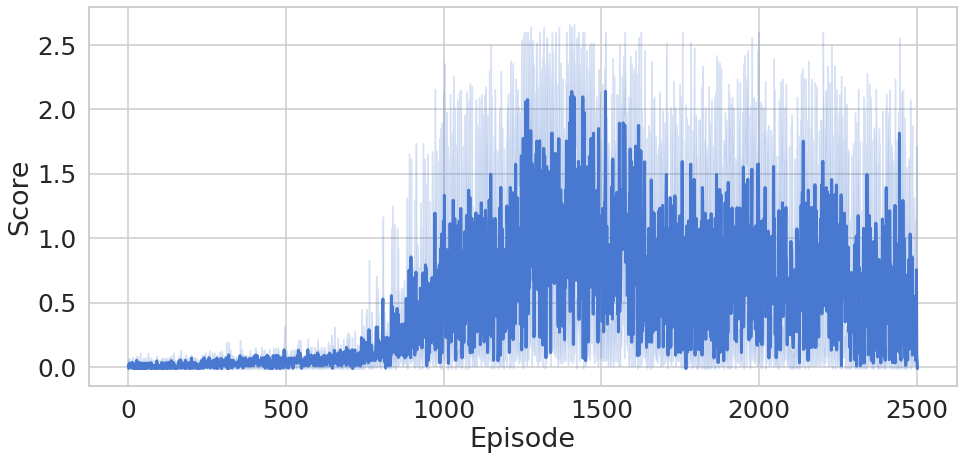

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

# Setup seaborn for plotting
sns.set("talk", font_scale=1.5,  rc={"lines.linewidth": 3, 'figure.figsize': (14, 7)})
sns.set_palette("muted")
sns.set_style("whitegrid")

# Get and arrange data
df = pd.read_csv("./score.csv")      # Read CSV file generated while training
df.columns = ["episodes", "scores"]  # Rename columns 

# Plot data
sns_plot = sns.lineplot('episodes', 'scores', data=df)
sns_plot.set(ylabel='Score', xlabel='Episode')
figure = sns_plot.get_figure()
figure.tight_layout()
plt.show()

<h1> Plot scores </h1>

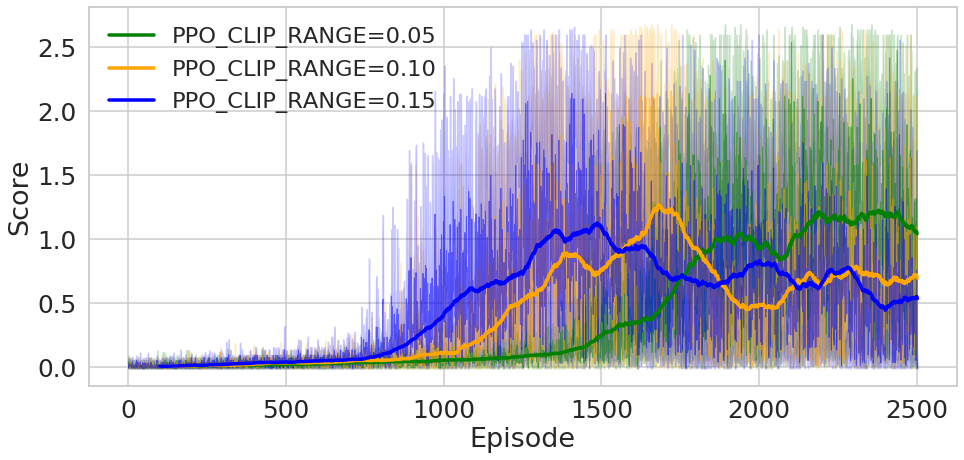

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

# Setup seaborn for plotting
sns.set("talk", font_scale=1.5,  rc={"lines.linewidth": 3, 'figure.figsize': (14, 7)})
sns.set_palette("muted")
sns.set_style("whitegrid")
 
# Get and arrange data
df05 = pd.read_csv("./data/score_0_05.csv")      # Read CSV file generated while training
df05.columns = ["episodes", "scores"]  # Rename columns 
df_scores_smooth05 = df05.groupby(["episodes"], as_index=False).mean()        # Prepare for rolling mean
df_scores_smooth05['smooth_score'] = df_scores_smooth05['scores'].rolling(100).mean() # Use rolling mean of 15

df1 = pd.read_csv("./data/score_0_1.csv")      # Read CSV file generated while training
df1.columns = ["episodes", "scores"]  # Rename columns
df_scores_smooth1 = df1.groupby(["episodes"], as_index=False).mean()        # Prepare for rolling mean
df_scores_smooth1['smooth_score'] = df_scores_smooth1['scores'].rolling(100).mean() # Use rolling mean of 15

df15 = pd.read_csv("./data/score_0_15.csv")      # Read CSV file generated while training
df15.columns = ["episodes", "scores"]  # Rename columns 
df_scores_smooth15 = df15.groupby(["episodes"], as_index=False).mean()        # Prepare for rolling mean
df_scores_smooth15['smooth_score'] = df_scores_smooth15['scores'].rolling(100).mean() # Use rolling mean of 15


# Plot data
sns_plot = sns.lineplot('episodes', 'scores', data=df05, linewidth = 1, color="green", alpha = 0.5, label='_nolegend_')
sns_plot = sns.lineplot('episodes', 'scores', data=df1, linewidth = 1, color="orange", alpha = 0.5, label='_nolegend_')
sns_plot = sns.lineplot('episodes', 'scores', data=df15, linewidth = 1, color="blue", alpha = 0.5, label='_nolegend_')

sns_plot = sns.lineplot('episodes', 'smooth_score', data=df_scores_smooth05, linewidth = 3.5, color="green")
sns_plot = sns.lineplot('episodes', 'smooth_score', data=df_scores_smooth1, linewidth = 3.5, color="orange")
sns_plot = sns.lineplot('episodes', 'smooth_score', data=df_scores_smooth15, linewidth = 3.5, color="blue")

sns_plot.set(ylabel='Score', xlabel='Episode')
sns_plot.legend(fontsize = 'small', loc='top left', labels=["PPO_CLIP_RANGE=0.05", "PPO_CLIP_RANGE=0.10", "PPO_CLIP_RANGE=0.15"], framealpha = 0)
figure = sns_plot.get_figure()
figure.tight_layout()
figure.savefig('./score_episode.png', dpi=200) # Save figure to score.png
plt.show()

<h1> Load and test trained agent </h1>

In [ ]:
agent         = PPO_algorithm(num_agents, state_size=state_size, action_size=action_size, hidden_size=32, seed=123)
agent.network.load_state_dict(torch.load('./saved_models/trained_weights.pth'))
train_session = train_agent(num_agents)
train_session.train_ppo(agent, 99.0, 300, False)